In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "used-car-price-dataset-competition-format"

# Importing the libraries

In [2]:
# Using advanced regression techniques to perform analysis on used car dataset
options(warn=-1)
# Importing libraries
library(caret)
library(glmnet)
library(ggplot2)
library(ranger)
library(e1071)
set.seed(1234)

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-1



# Importing data sets

In [3]:
X_train <- read.csv2('../input/used-car-price-dataset-competition-format/X_train.csv', sep = ',')
X_test <- read.csv('../input/used-car-price-dataset-competition-format/X_test.csv', sep = ',')
y_train <- read.csv('../input/used-car-price-dataset-competition-format/y_train.csv', sep = ',')
y_test <- read.csv('../input/used-car-price-dataset-competition-format/test_label/y_test.csv', sep = ',')

# Exploratory Data Analysis 

In [4]:
# We bind all the data together and then reshuffle it to remove any splitting bias beforehand.
# Merging with carID as it is unique
train_full <- merge(X_train, y_train, by = 'carID')
test_full <- merge(X_test, y_test, by = 'carID')

full_data <- rbind(train_full, test_full)

# Removing carID as it doesn't serve any useful purpose in our analysis
full_data <- select(full_data, -carID)

In [5]:
head(full_data)  # We see that some columns do not have correct data types

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>
1,hyundi,Santa Fe,2017,Semi-Auto,32467,Diesel,235.0,42.8,2.2,18991
2,vw,Arteon,2019,Automatic,1555,Petrol,145.0,40.4,1.5,22500
3,toyota,Verso,2003,Automatic,104000,Petrol,300.0,34.5,1.8,2395
4,ford,Grand C-MAX,2018,Manual,5113,Petrol,145.0,47.9,1.0,14000
5,bmw,X6,2019,Automatic,9010,Diesel,145.0,34.9,3.0,58700
6,toyota,Prius,2016,Automatic,32853,Hybrid,10.0,64.2,1.8,22995


In [6]:
anyNA(full_data)

[1] FALSE

In [7]:
# We change the data types according to the data 
full_data <- mutate_at(full_data, c(7,8,9), as.double)  # Changing character to double
full_data <- full_data %>% mutate_if(is.character, ~as.factor(.))   # Changing character to factors as they are categories
full_data <- mutate_at(full_data, c(3), as.factor) # Changing year as a factor

In [8]:
head(full_data)

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<int>
1,hyundi,Santa Fe,2017,Semi-Auto,32467,Diesel,235,42.8,2.2,18991
2,vw,Arteon,2019,Automatic,1555,Petrol,145,40.4,1.5,22500
3,toyota,Verso,2003,Automatic,104000,Petrol,300,34.5,1.8,2395
4,ford,Grand C-MAX,2018,Manual,5113,Petrol,145,47.9,1.0,14000
5,bmw,X6,2019,Automatic,9010,Diesel,145,34.9,3.0,58700
6,toyota,Prius,2016,Automatic,32853,Hybrid,10,64.2,1.8,22995


In [9]:
dim(full_data)

[1] 7632   10

In [10]:
library(repr)

In [11]:
fig_size <- function(width, height){
    options(repr.plot.width=width, repr.plot.height = height)
}

In [12]:
brands <- full_data %>% group_by(brand) %>% summarise(length(brand))

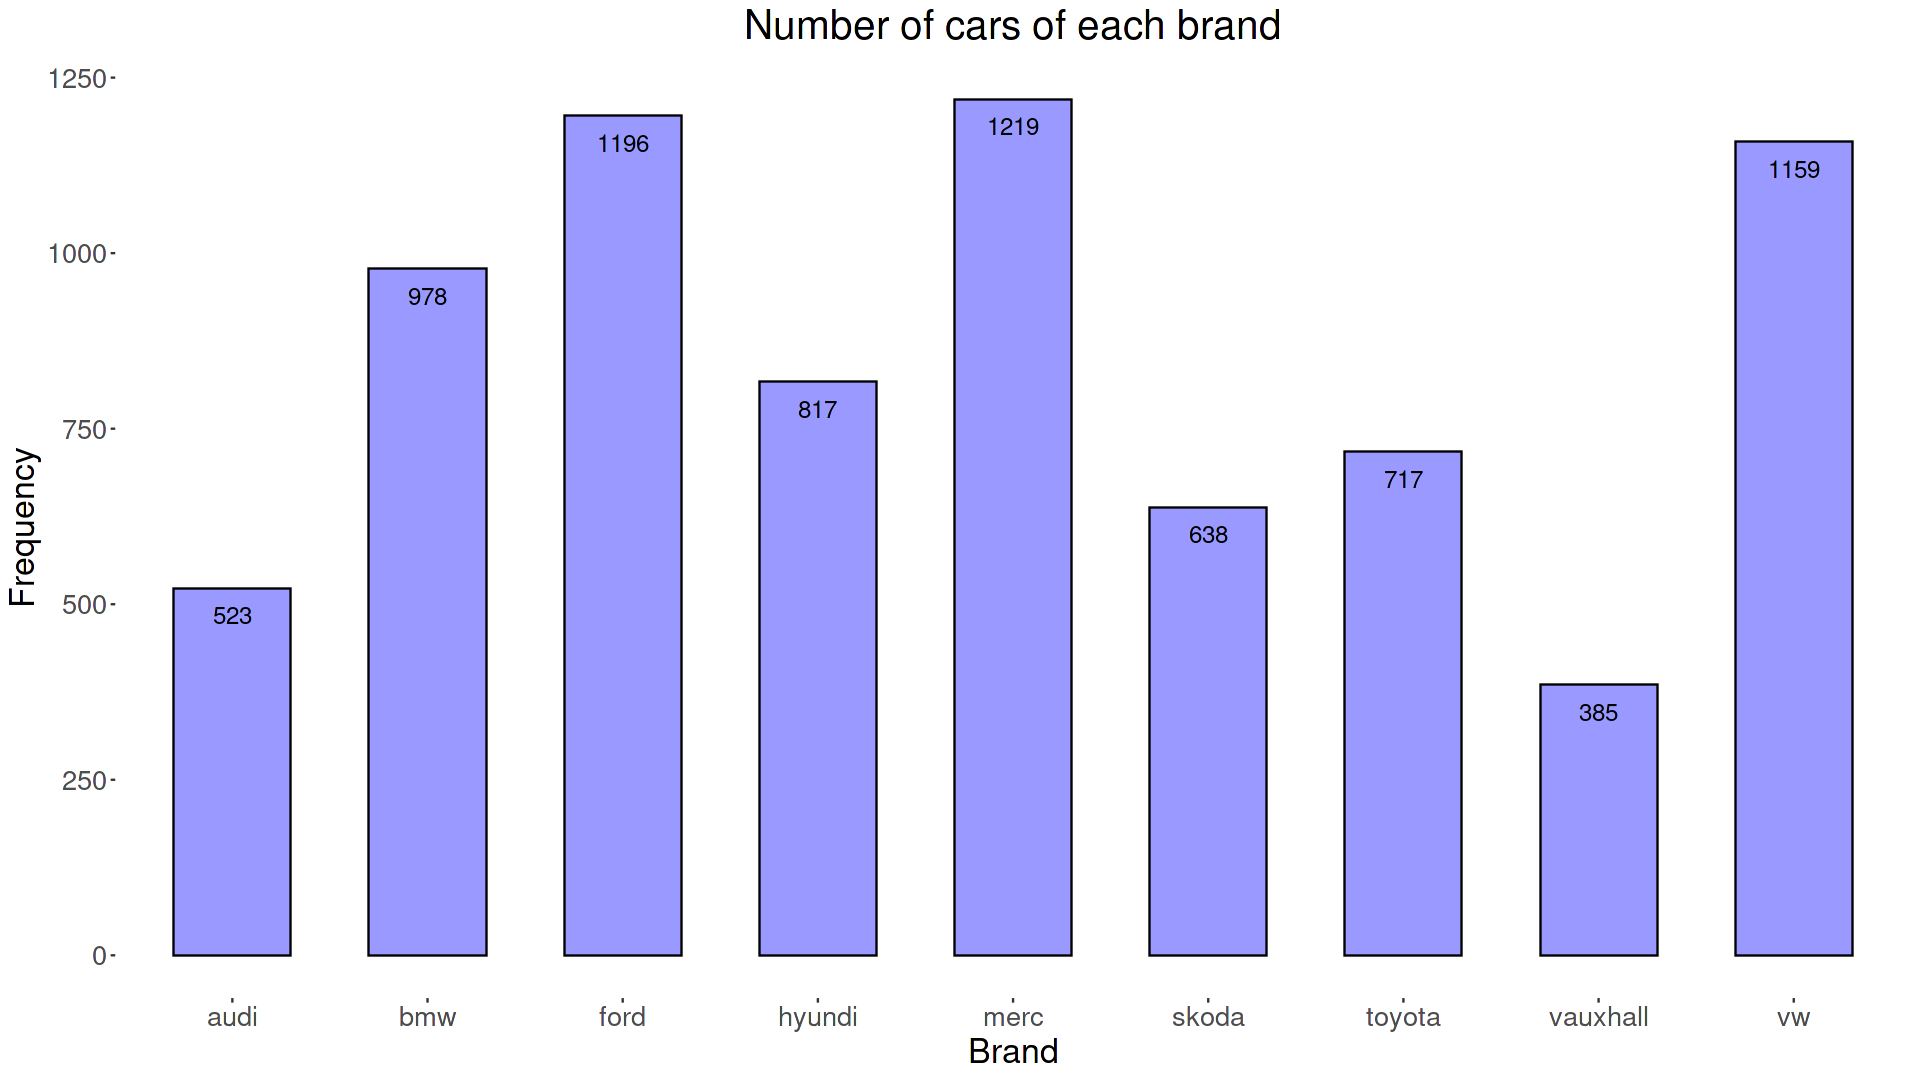

In [13]:
fig_size(16,9)

ggplot(data = brands, aes(x = brand, y = `length(brand)`)) + 
  geom_bar( stat= 'identity', width=0.6, fill = '#9999FF', color='black') + 
  geom_text(aes(label = `length(brand)` ), vjust=2,size = 5) +
  xlab('Brand') + 
  ylab('Frequency') + 
  ggtitle('Number of cars of each brand') +
  theme(panel.grid.major = element_blank(), 
        panel.background = element_rect('white'),
        text = element_text(size = 20),
        plot.title = element_text(hjust = 0.5))

# Number of cars from each brand in the dataset


In [14]:
bybrand <- full_data %>% group_by(brand, transmission) %>% summarise(price = mean(price))

`summarise()` has grouped output by 'brand'. You can override using the `.groups` argument.



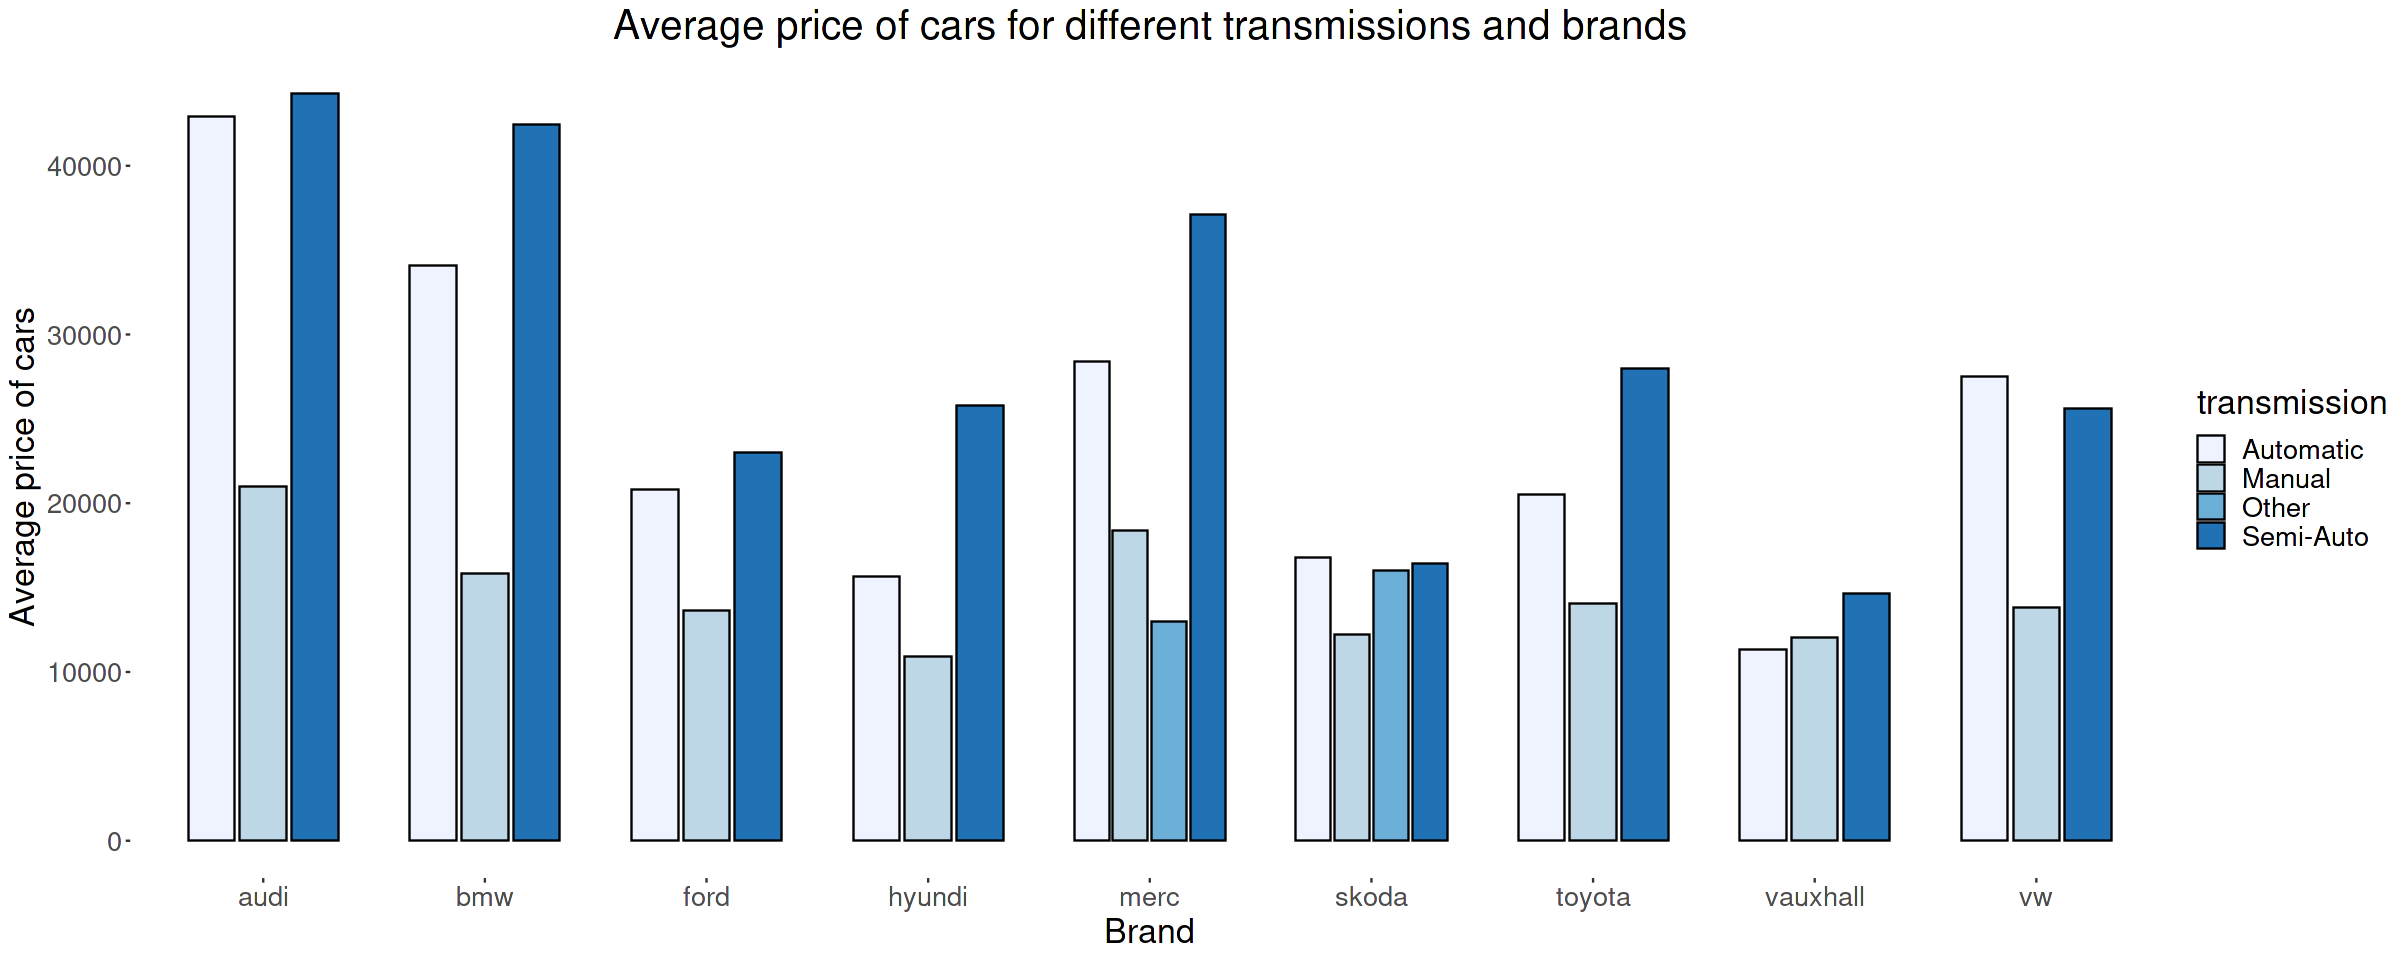

In [15]:
fig_size(20,8)
ggplot(data = bybrand, aes(x = brand, y = price, fill= transmission))+
  geom_bar(stat='identity', position = position_dodge2(),width=0.7, color='black') +
  xlab('Brand')+
  ylab('Average price of cars') +
  scale_fill_brewer()+
  ggtitle('Average price of cars for different transmissions and brands')+
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.background = element_rect('white'),
        text = element_text(size = 20),
        plot.title = element_text(hjust = 0.5))

# On an average, semi-auto version in Audi is the costliest


In [16]:
taxincur <- full_data %>% group_by(fuelType) %>% summarise(tax = tax)


`summarise()` has grouped output by 'fuelType'. You can override using the `.groups` argument.



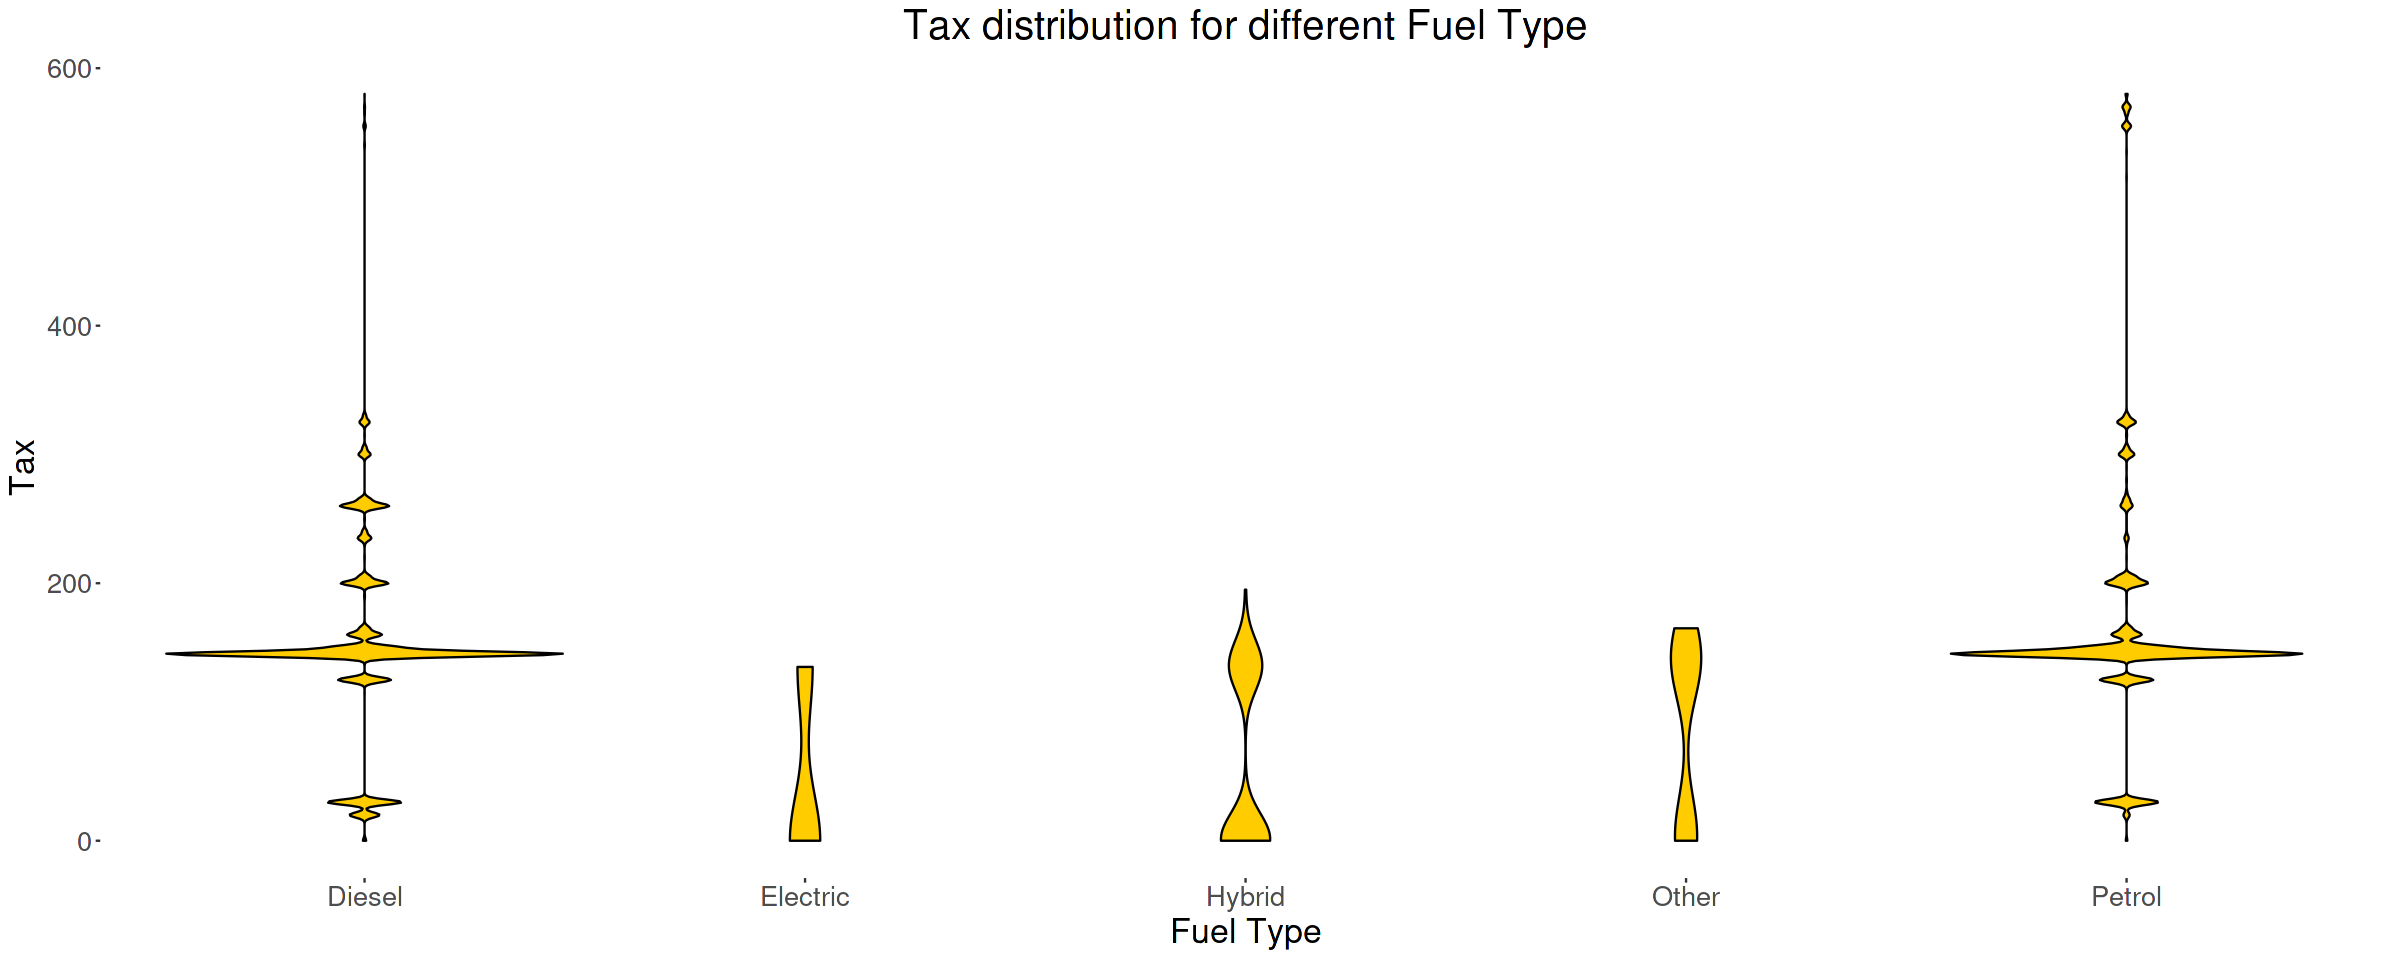

In [17]:
ggplot(data = taxincur, aes(x = fuelType, y = tax))+
  geom_violin(fill = '#FFCC00', color='black') +
  xlab('Fuel Type')+
  ylab('Tax') +
  ggtitle('Tax distribution for different Fuel Type') +
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.background = element_rect('white'),
        text = element_text(size = 20),
        plot.title = element_text(hjust = 0.5))

# As we see, taxes are very strict for petrol and diesel cars and almost zero for electric cars

In [18]:
byfuel <- full_data %>% group_by(brand, fuelType) %>% summarise(price = mean(price))


`summarise()` has grouped output by 'brand'. You can override using the `.groups` argument.



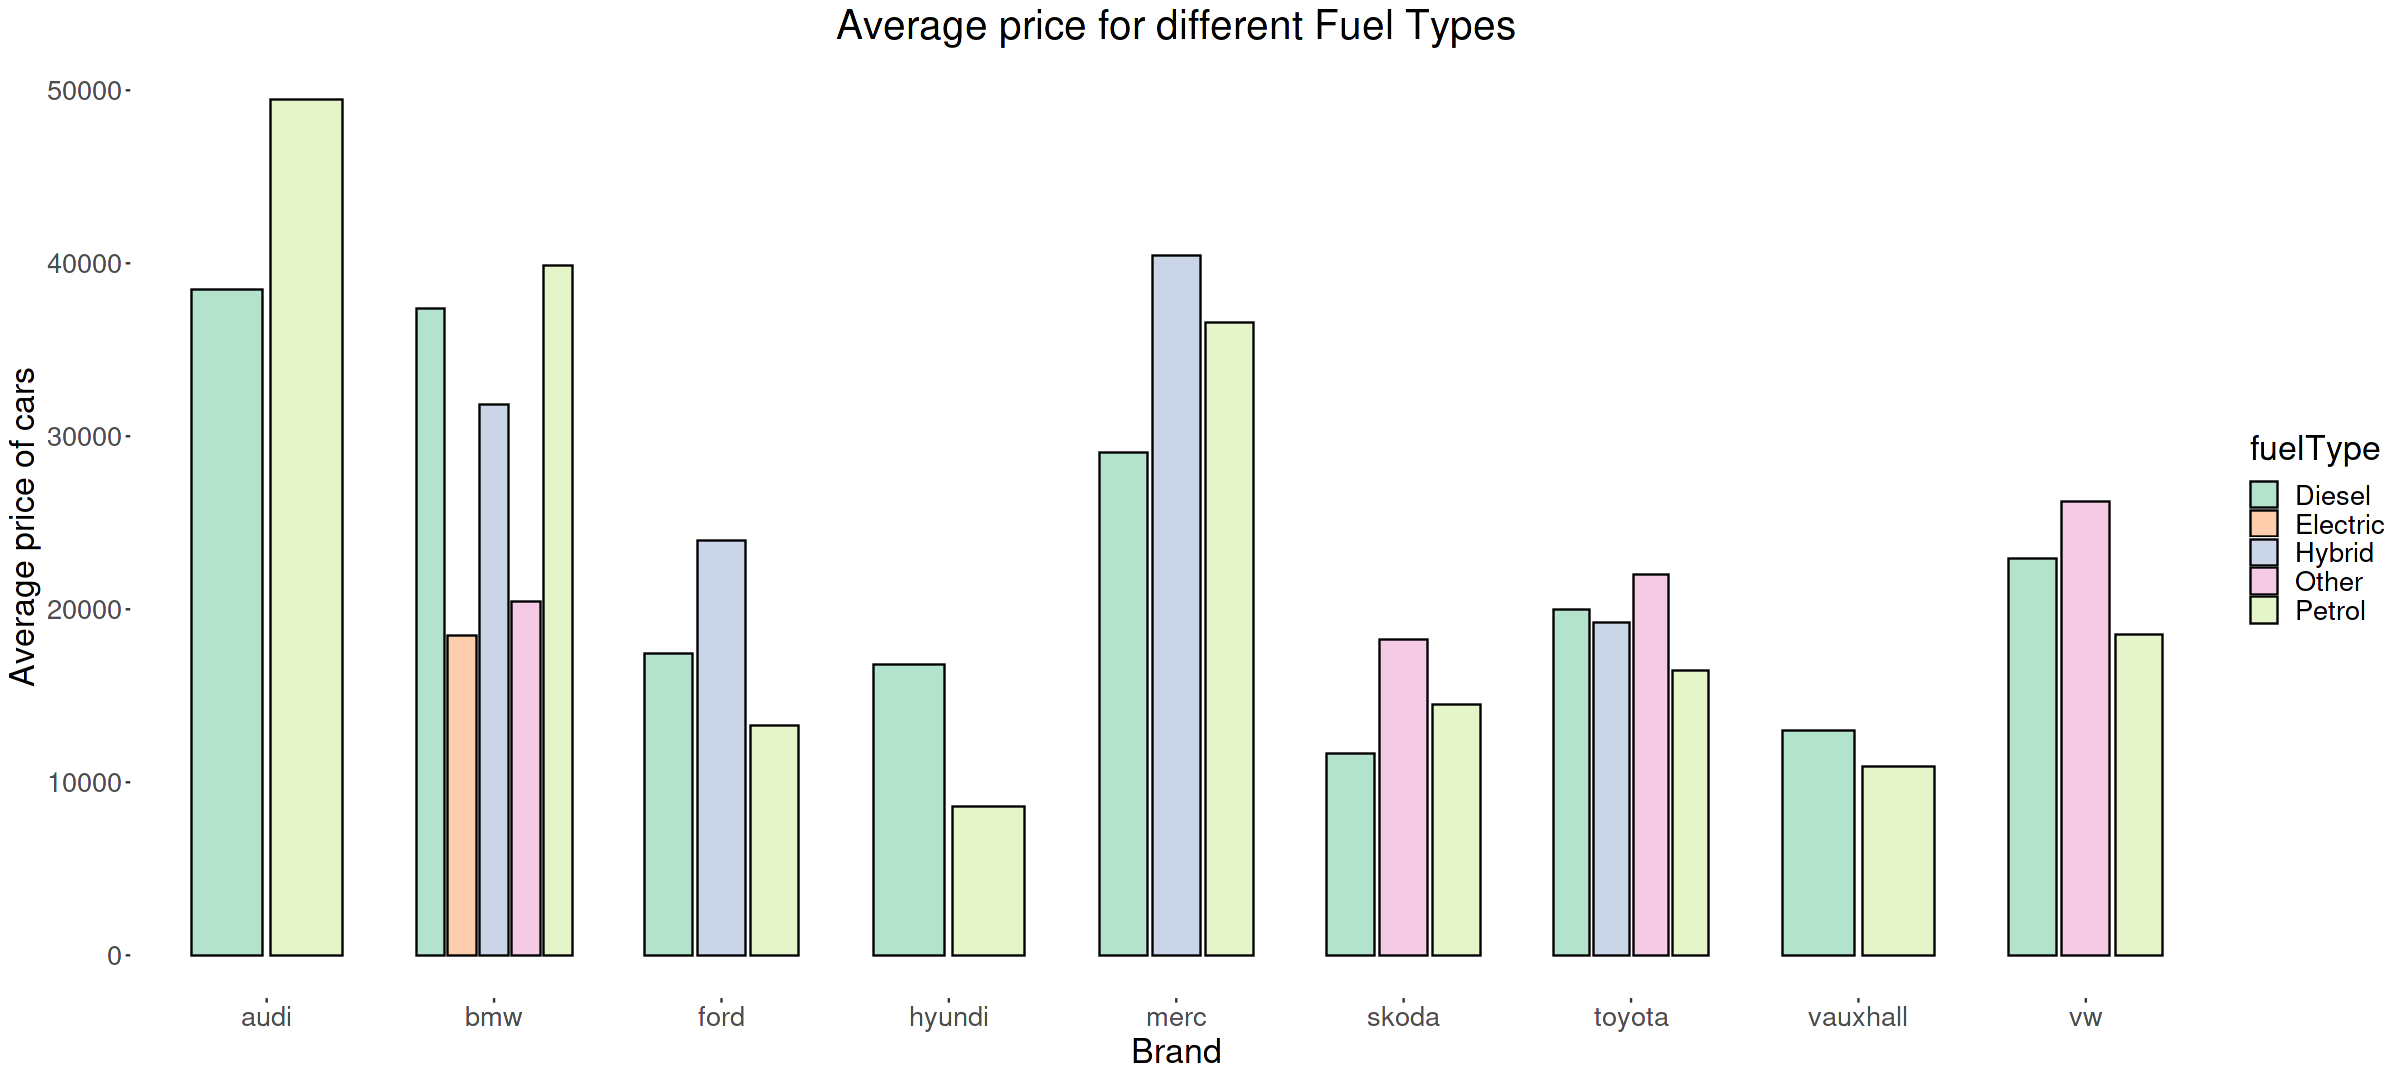

In [19]:
fig_size(20,9)
ggplot(data = byfuel, aes(x = brand, y = price, fill=fuelType)) +
geom_bar(stat = 'identity', position = position_dodge2(), width=0.7, color = 'black')+
xlab('Brand')+
ylab('Average price of cars') +
scale_fill_brewer(palette = 'Pastel2') +
ggtitle('Average price for different Fuel Types')+
theme(panel.grid.major = element_blank(), 
        panel.background = element_rect('white'),
        text = element_text(size = 20),
        plot.title = element_text(hjust = 0.5))

# Prices for Petrol cars is highest on an average, BMW is the only brand with electric cars

In [20]:
years <- full_data %>% group_by(year) %>% summarise(length(year))

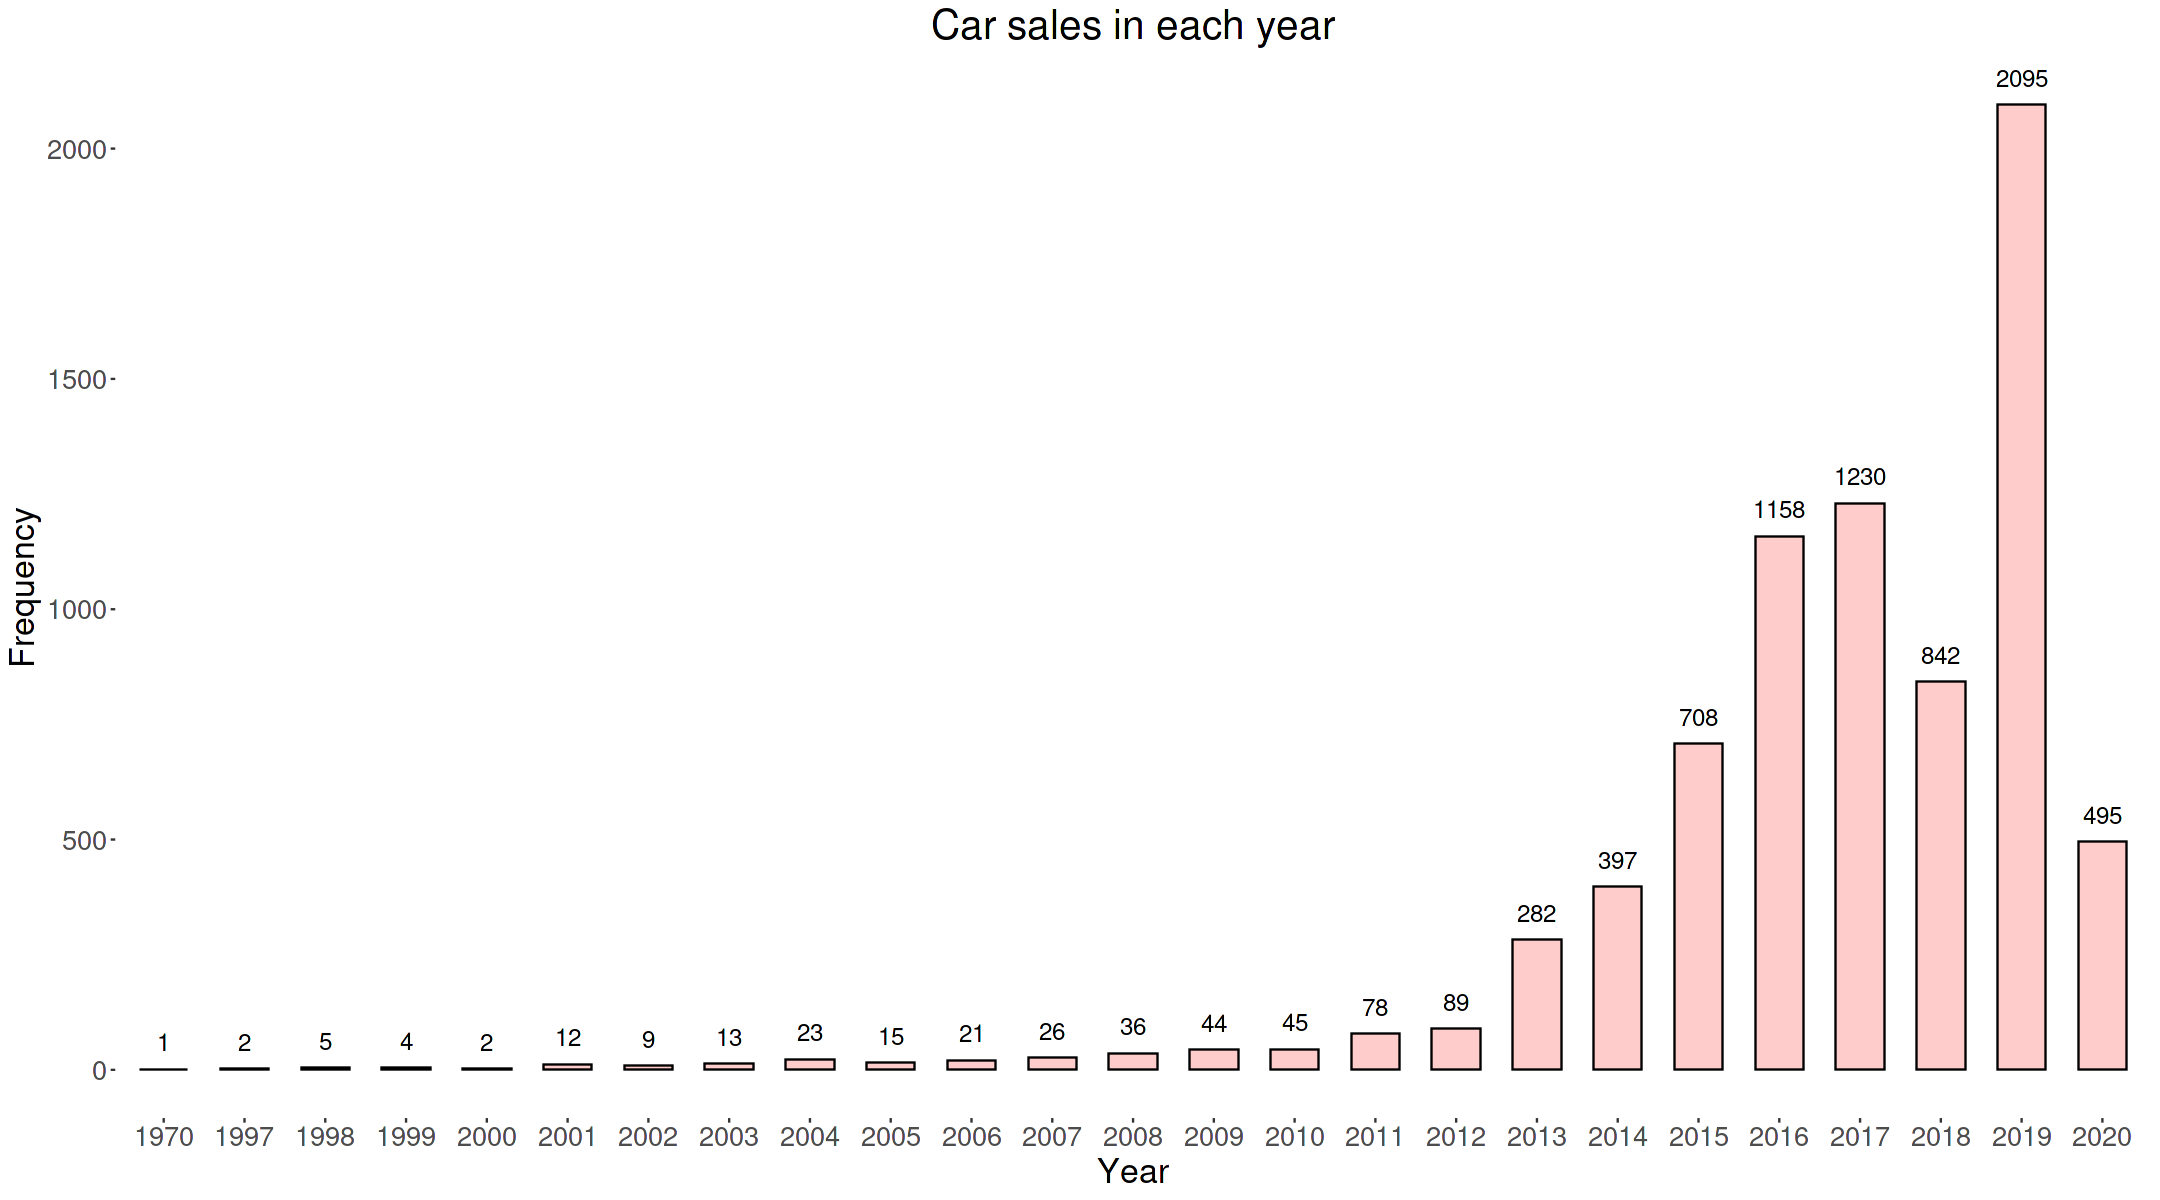

In [21]:
fig_size(18,10)
ggplot(data = years, aes(x = year, y = `length(year)`)) + 
  geom_bar(stat = 'identity', width=0.6, fill = '#FFCCCC', color='black') + 
  geom_text(aes(label = `length(year)`), vjust = -1, size = 5 ) +
  xlab('Year') + 
  ylab('Frequency') +
  ggtitle('Car sales in each year') + 
  theme(panel.grid.major = element_blank(), 
        panel.background = element_rect('white'),
        text = element_text(size = 20),
        plot.title = element_text(hjust = 0.5))

# Most of the cars were bought in 2019 

In [22]:
# Let's see which fuelType provides the most miles per gallon and how are they priced
byfuelmpg <- full_data %>% group_by(fuelType) %>% summarize(mpg = mean(mpg), price = mean(price))
byfuelmpg

fuelType,mpg,price
<fct>,<dbl>,<dbl>
Diesel,48.05782,24166.90
Electric,470.80000,18466.00
Hybrid,137.76376,22221.52
Other,161.70000,21366.08
Petrol,42.40373,22734.30


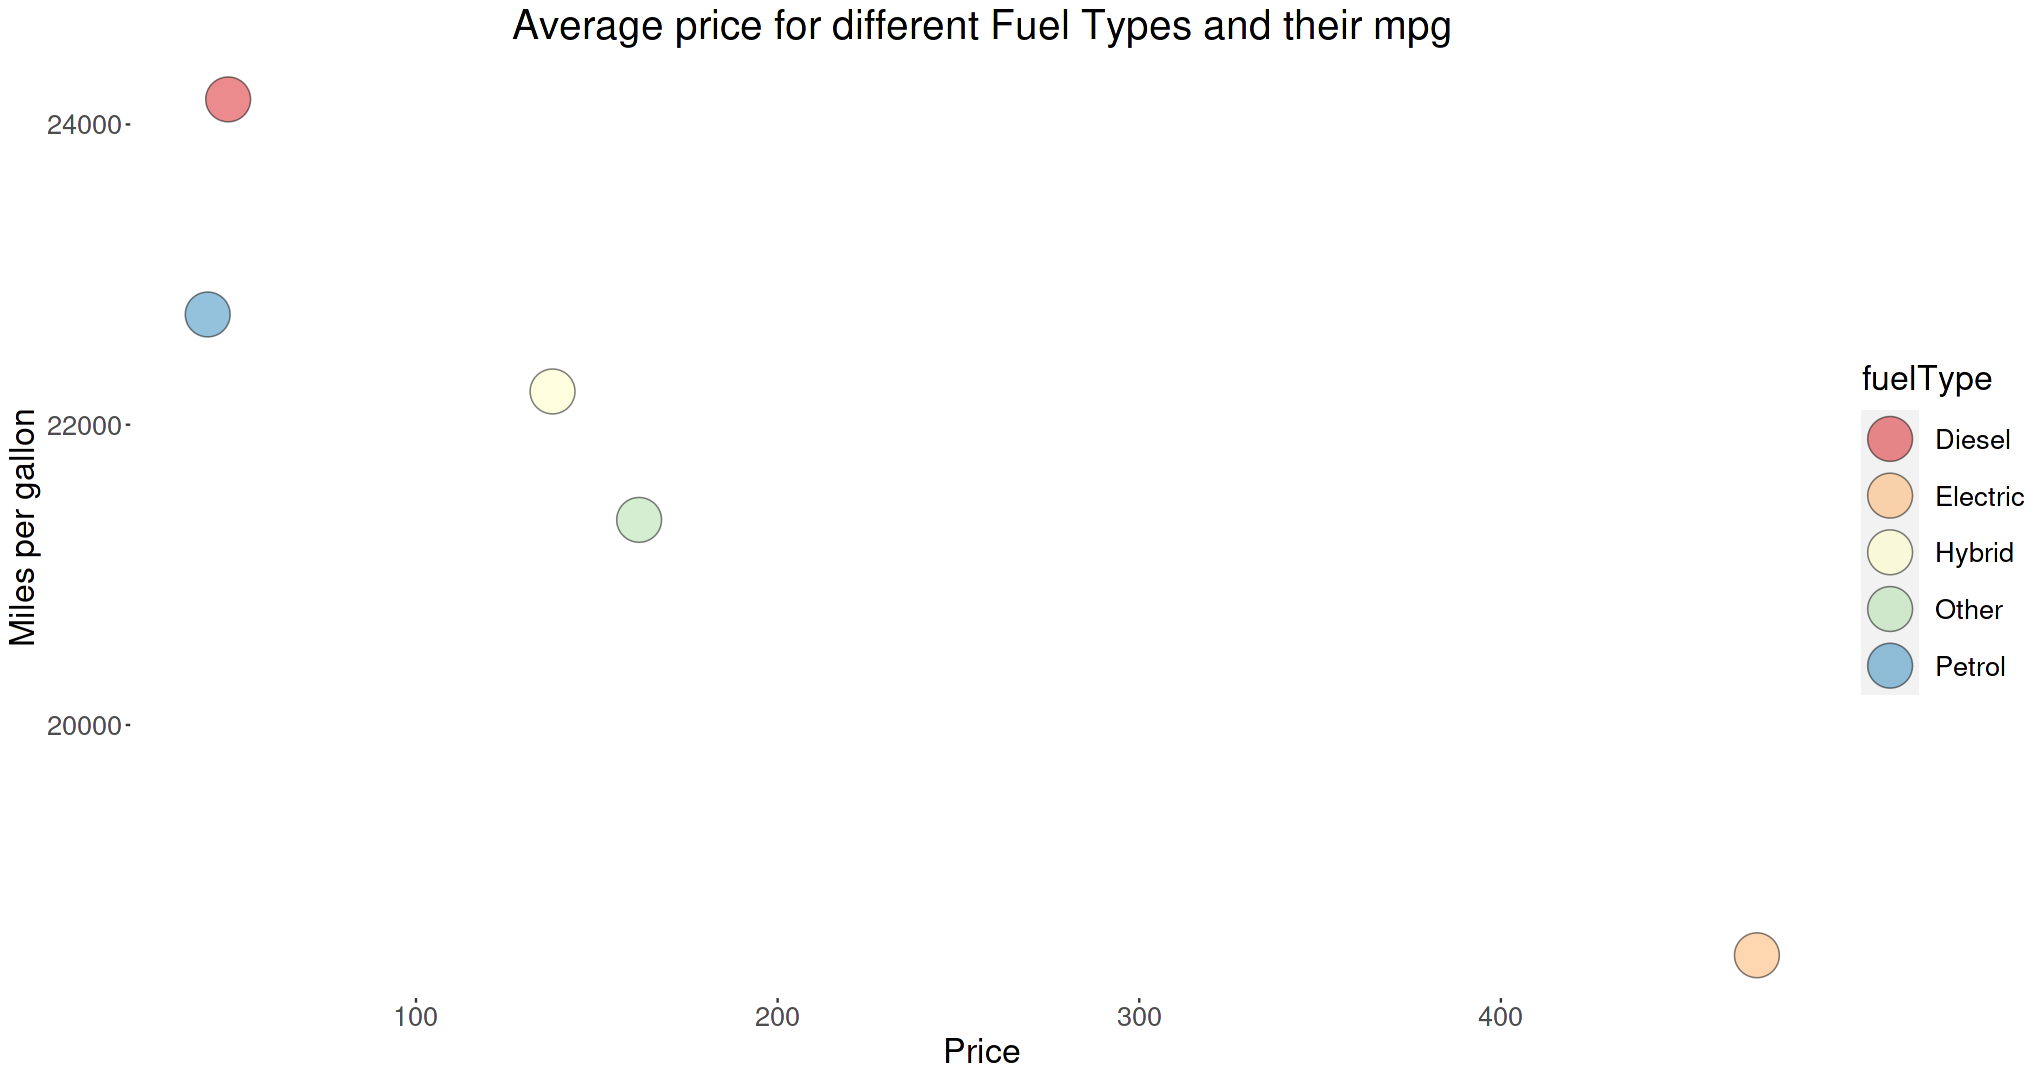

In [23]:
fig_size(17,9)
ggplot(data = byfuelmpg, aes(x= mpg, y = price, fill=fuelType)) +
geom_point(size = 12, alpha = 0.5, shape=21, color='black') +
xlab('Price') +
ylab('Miles per gallon') +
scale_fill_brewer(palette = 'Spectral') +
ggtitle('Average price for different Fuel Types and their mpg')+
theme(panel.grid.major = element_blank(), 
        panel.background = element_rect('white'),
        text = element_text(size = 20),
        plot.title = element_text(hjust = 0.5))

# We see that elecrtic cars have the lowest average price but highest efficiency, maybe we have less data points to support more information.
# Also, Diesel cars most costly with the lowest mpg


In [24]:
head(full_data)

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<int>
1,hyundi,Santa Fe,2017,Semi-Auto,32467,Diesel,235,42.8,2.2,18991
2,vw,Arteon,2019,Automatic,1555,Petrol,145,40.4,1.5,22500
3,toyota,Verso,2003,Automatic,104000,Petrol,300,34.5,1.8,2395
4,ford,Grand C-MAX,2018,Manual,5113,Petrol,145,47.9,1.0,14000
5,bmw,X6,2019,Automatic,9010,Diesel,145,34.9,3.0,58700
6,toyota,Prius,2016,Automatic,32853,Hybrid,10,64.2,1.8,22995


`geom_smooth()` using formula 'y ~ x'



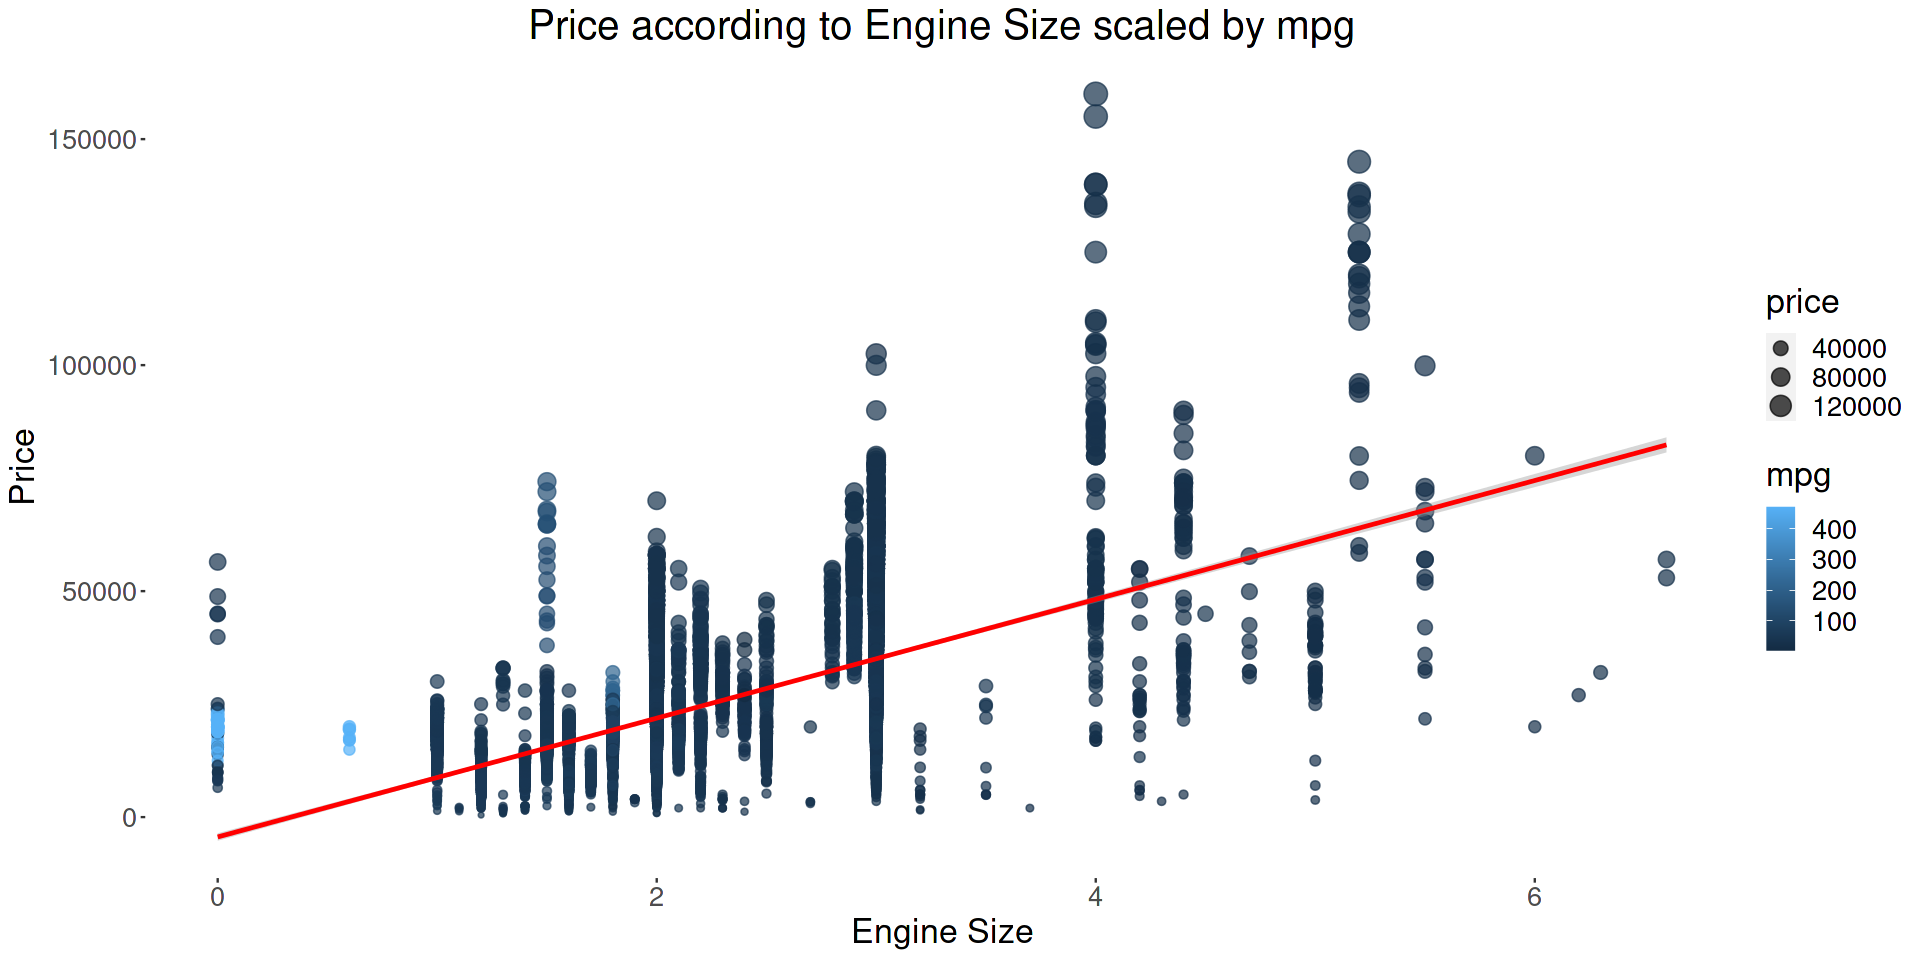

In [25]:
# Let's check out some continuos variables and their distributions
fig_size(16,8)
ggplot(data = full_data, aes(x=engineSize, y=price)) +
geom_point(aes(size=price, color=mpg), alpha = 0.7)+
geom_smooth(method='lm', se=T, color ='red') +
xlab('Engine Size')+ 
scale_fill_brewer(palette = 'Set2')+
ggtitle('Price according to Engine Size scaled by mpg')+
ylab('Price') +
theme(panel.grid.major = element_blank(), 
        panel.background = element_rect('white'),
        text = element_text(size = 20),
        plot.title = element_text(hjust = 0.5))

# It looks like engines with really less size have relatively more average than heavy engines and are less costly. Heavier the engine, more the price

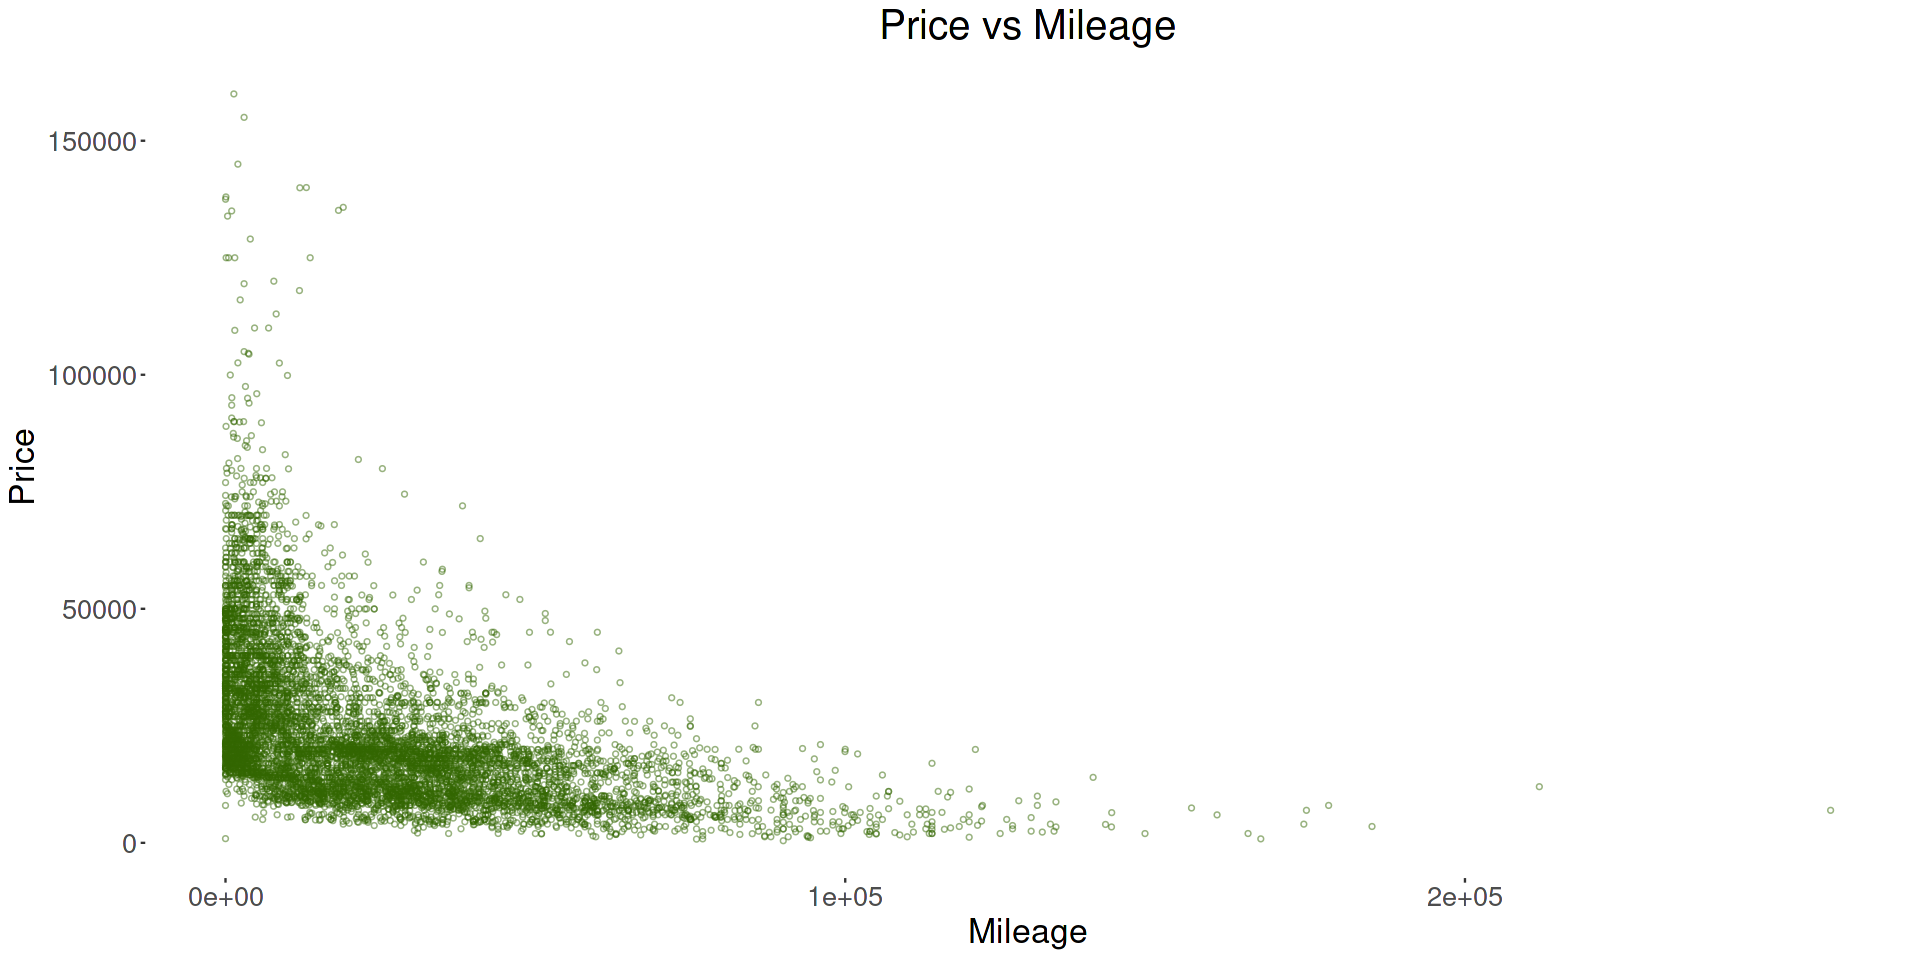

In [26]:
# Let's check out some continuos variables and their distributions
fig_size(16,8)
ggplot(data = full_data, aes(x=mileage, y=price)) +
geom_point(color='#336600', shape=21, alpha = 0.5, size=1)+
xlab('Mileage')+ 
scale_fill_distiller()+
ylab('Price') +
ggtitle('Price vs Mileage')+
theme(panel.grid.major = element_blank(), 
        panel.background = element_rect('white'),
        text = element_text(size = 20),
        plot.title = element_text(hjust = 0.5))

# The graph doesn't look good, let's check the mileage and price columns seperately

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



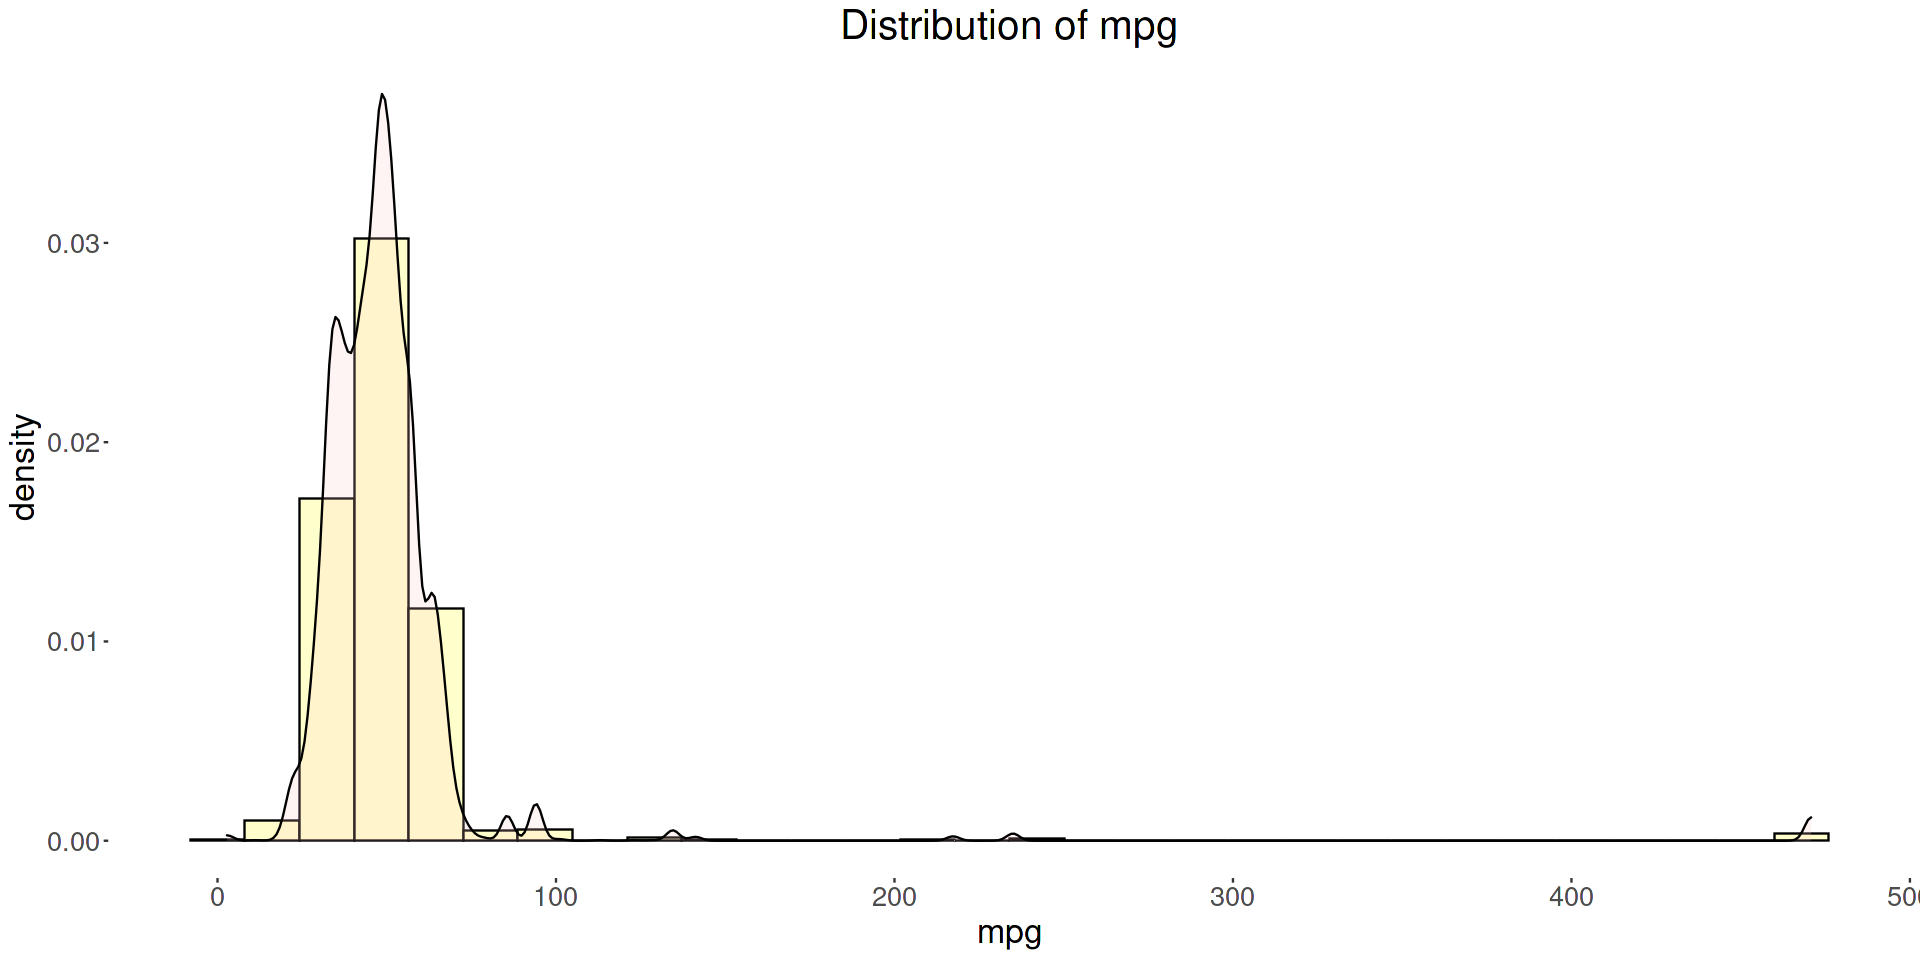

In [27]:
ggplot(data=full_data,aes(x=(mpg)))+
geom_histogram(aes(y=..density..), fill='#FFFFCC', color='black')+
geom_density(alpha=0.2,fill="#FFCCCC")+
xlab('mpg')+
ggtitle('Distribution of mpg')+
theme(panel.grid.major = element_blank(), 
        panel.background = element_rect('white'),
        text = element_text(size = 20),
        plot.title = element_text(hjust = 0.5))

### Log Transformation needed, But why? 

You can see that the center case (y) has been transformed to symmetry, while the more mildly right skew case (x) is now somewhat left skew. One the other hand, the most skew variable (z) is still (slightly) right skew, even after taking logs.

If we wanted our distributions to look more normal, the transformation definitely improved the second and third case. We can see that this might help.

Taking logs "pulls in" more extreme values on the right (high values) relative to the median, while values at the far left (low values) tend to get stretched back, further away from the median. 

![log transformations](https://i.stack.imgur.com/7iSYs.png)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



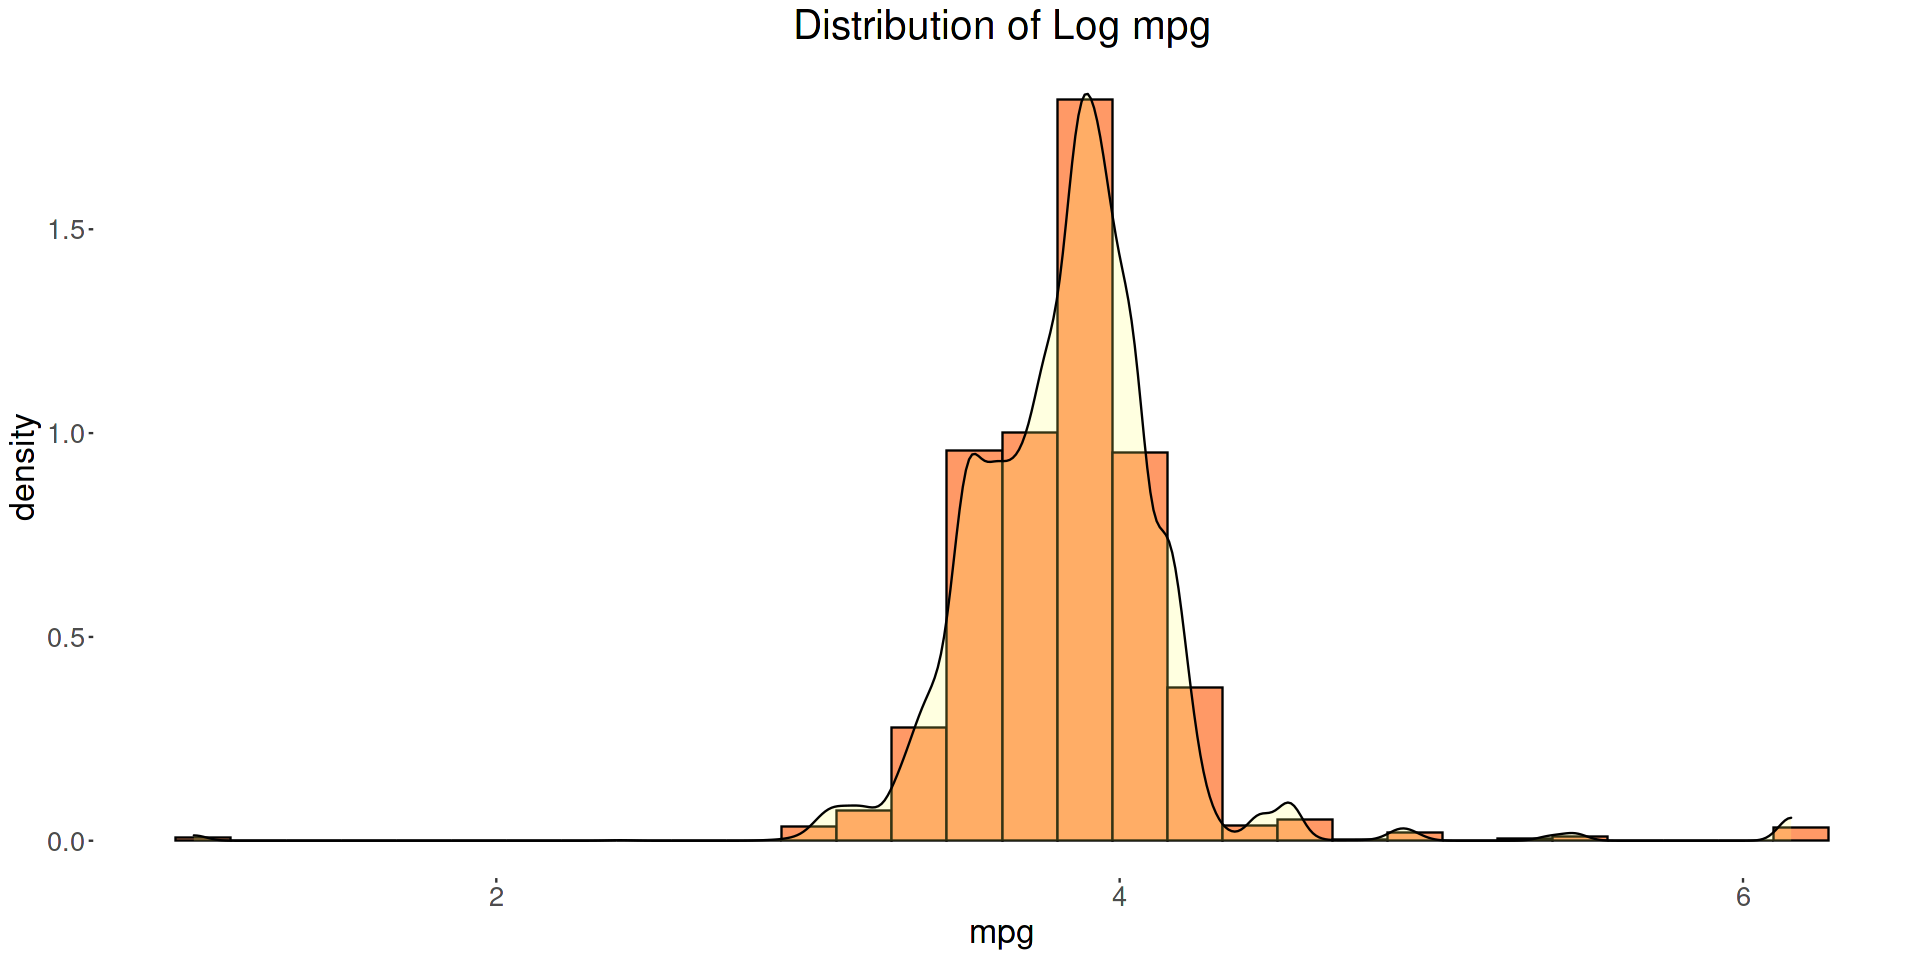

In [28]:
ggplot(data=full_data,aes(x=log(mpg)))+
geom_histogram(aes(y=..density..), fill='#FF9966', color='black')+
geom_density(alpha=0.2,fill="#FFFF66")+
xlab('mpg')+
ggtitle('Distribution of Log mpg')+
theme(panel.grid.major = element_blank(), 
        panel.background = element_rect('white'),
        text = element_text(size = 20),
        plot.title = element_text(hjust = 0.5))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



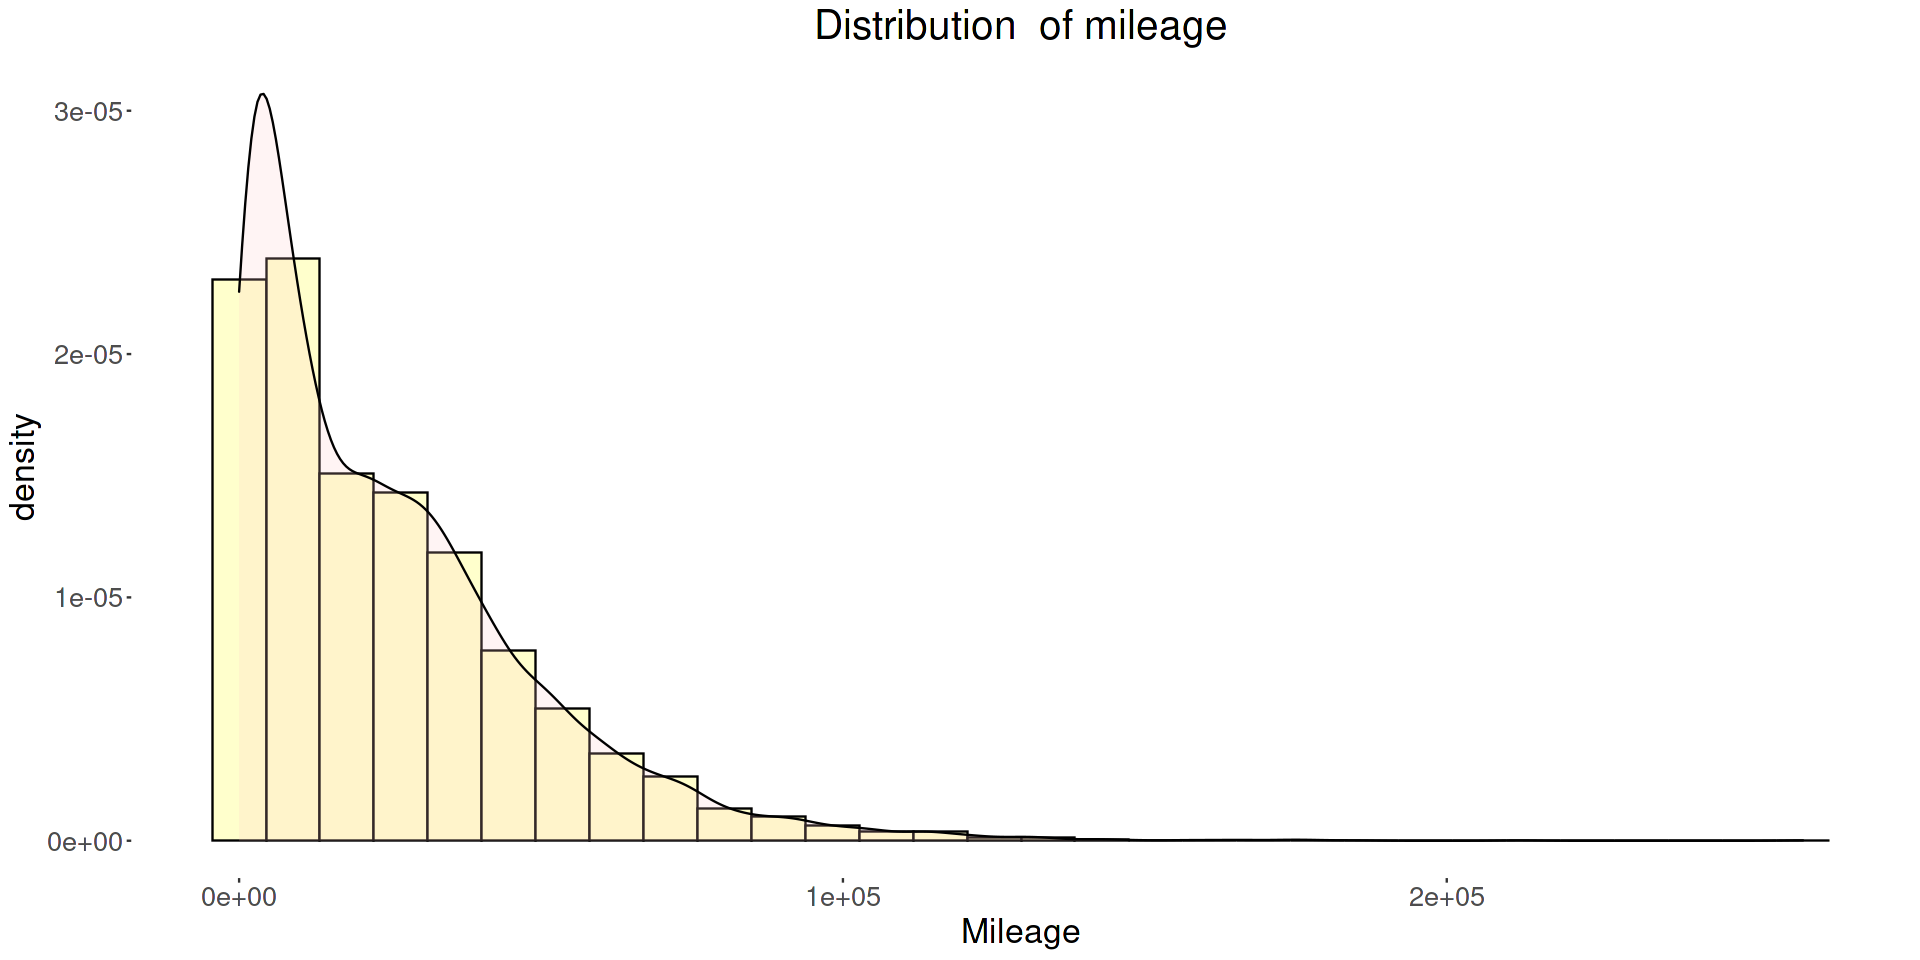

In [29]:
ggplot(data=full_data,aes(x=mileage))+
geom_histogram(aes(y=..density..), fill='#FFFFCC', color='black')+
geom_density(alpha=0.2,fill="#FFCCCC")+
xlab('Mileage')+
ggtitle('Distribution  of mileage')+
theme(panel.grid.major = element_blank(), 
        panel.background = element_rect('white'),
        text = element_text(size = 20),
        plot.title = element_text(hjust = 0.5))

# It looks positively skewed and that is a problem as it will mess with our prediction error but we can solve it with log transformation

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



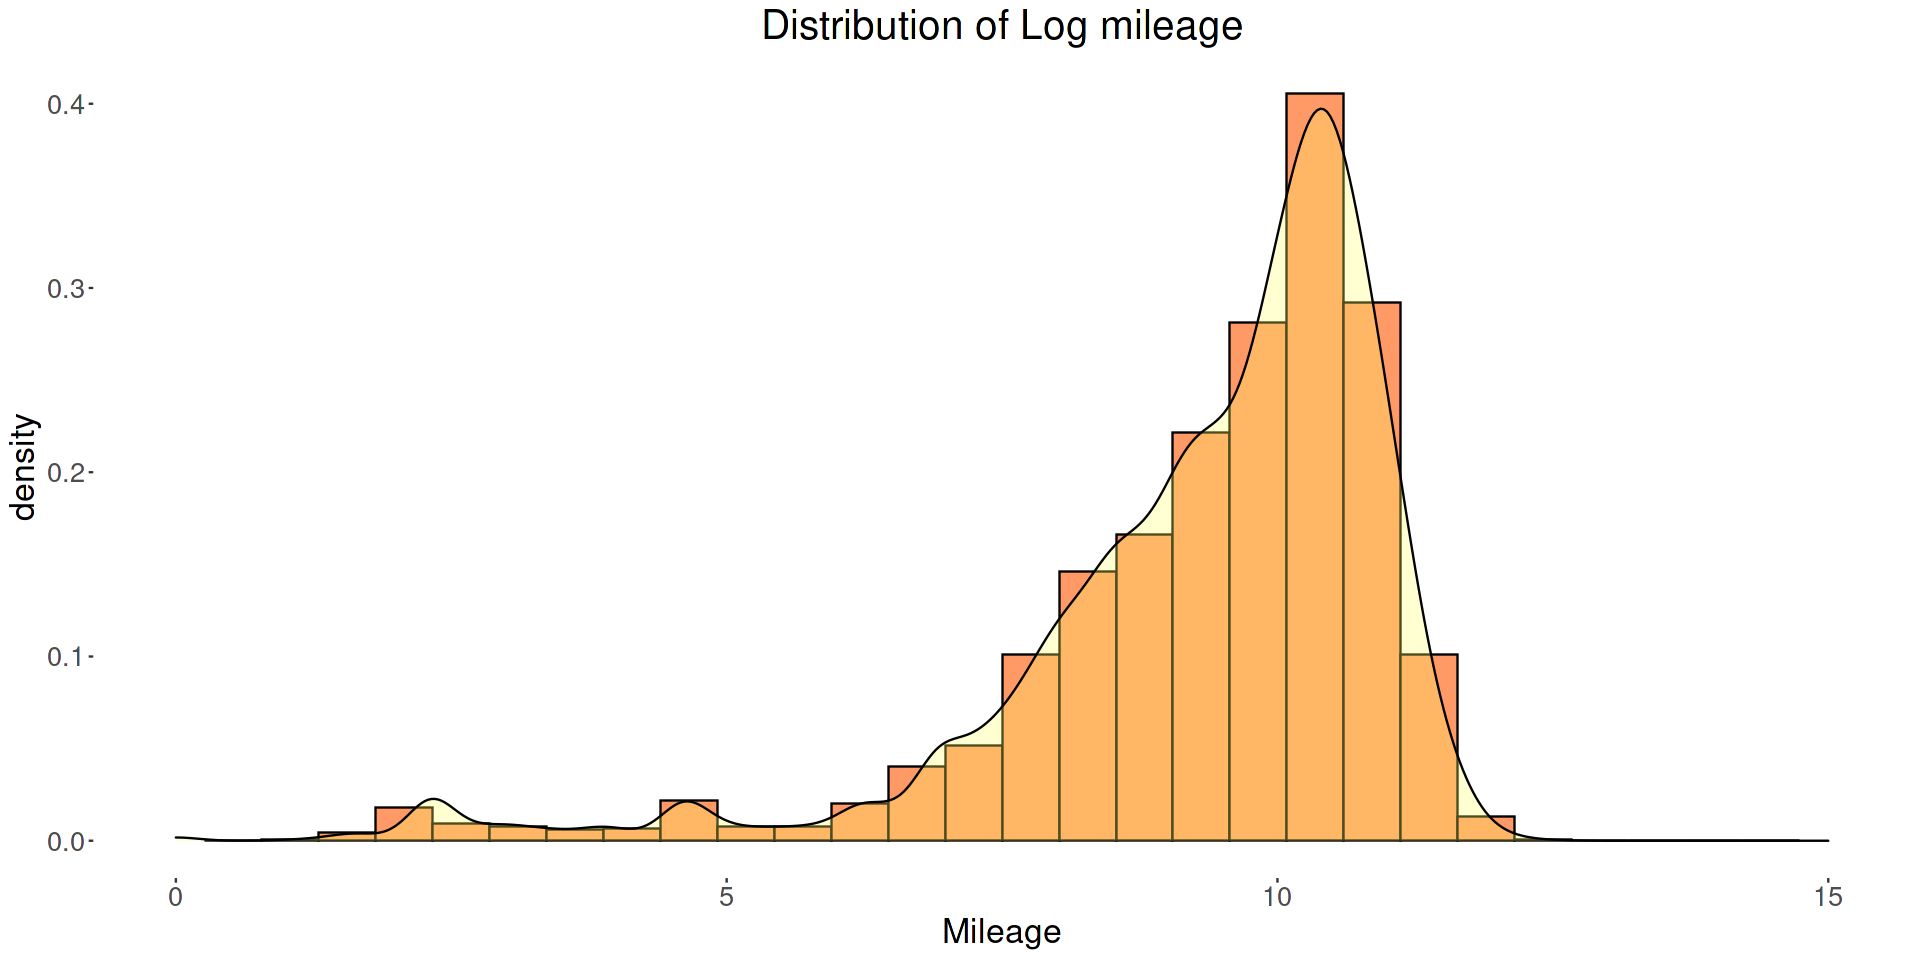

In [30]:
ggplot(data=full_data,aes(x=log(mileage)))+
geom_histogram(aes(y=..density..), fill='#FF9966', color='black')+
geom_density(alpha=0.3,fill="#FFFF66")+
xlab('Mileage')+
xlim(c(0,15))+
ggtitle('Distribution of Log mileage')+
theme(panel.grid.major = element_blank(), 
        panel.background = element_rect('white'),
        text = element_text(size = 20),
        plot.title = element_text(hjust = 0.5))

###  It doesn't make our data perfectly normal but that will mostly not happen in practice. I used other transformations also like sqrt, cubic root but this gives the maximum R square value and since model inference is not our objective here, we can use transformations without the primary aim of interpreting our models and focus more on predictions.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



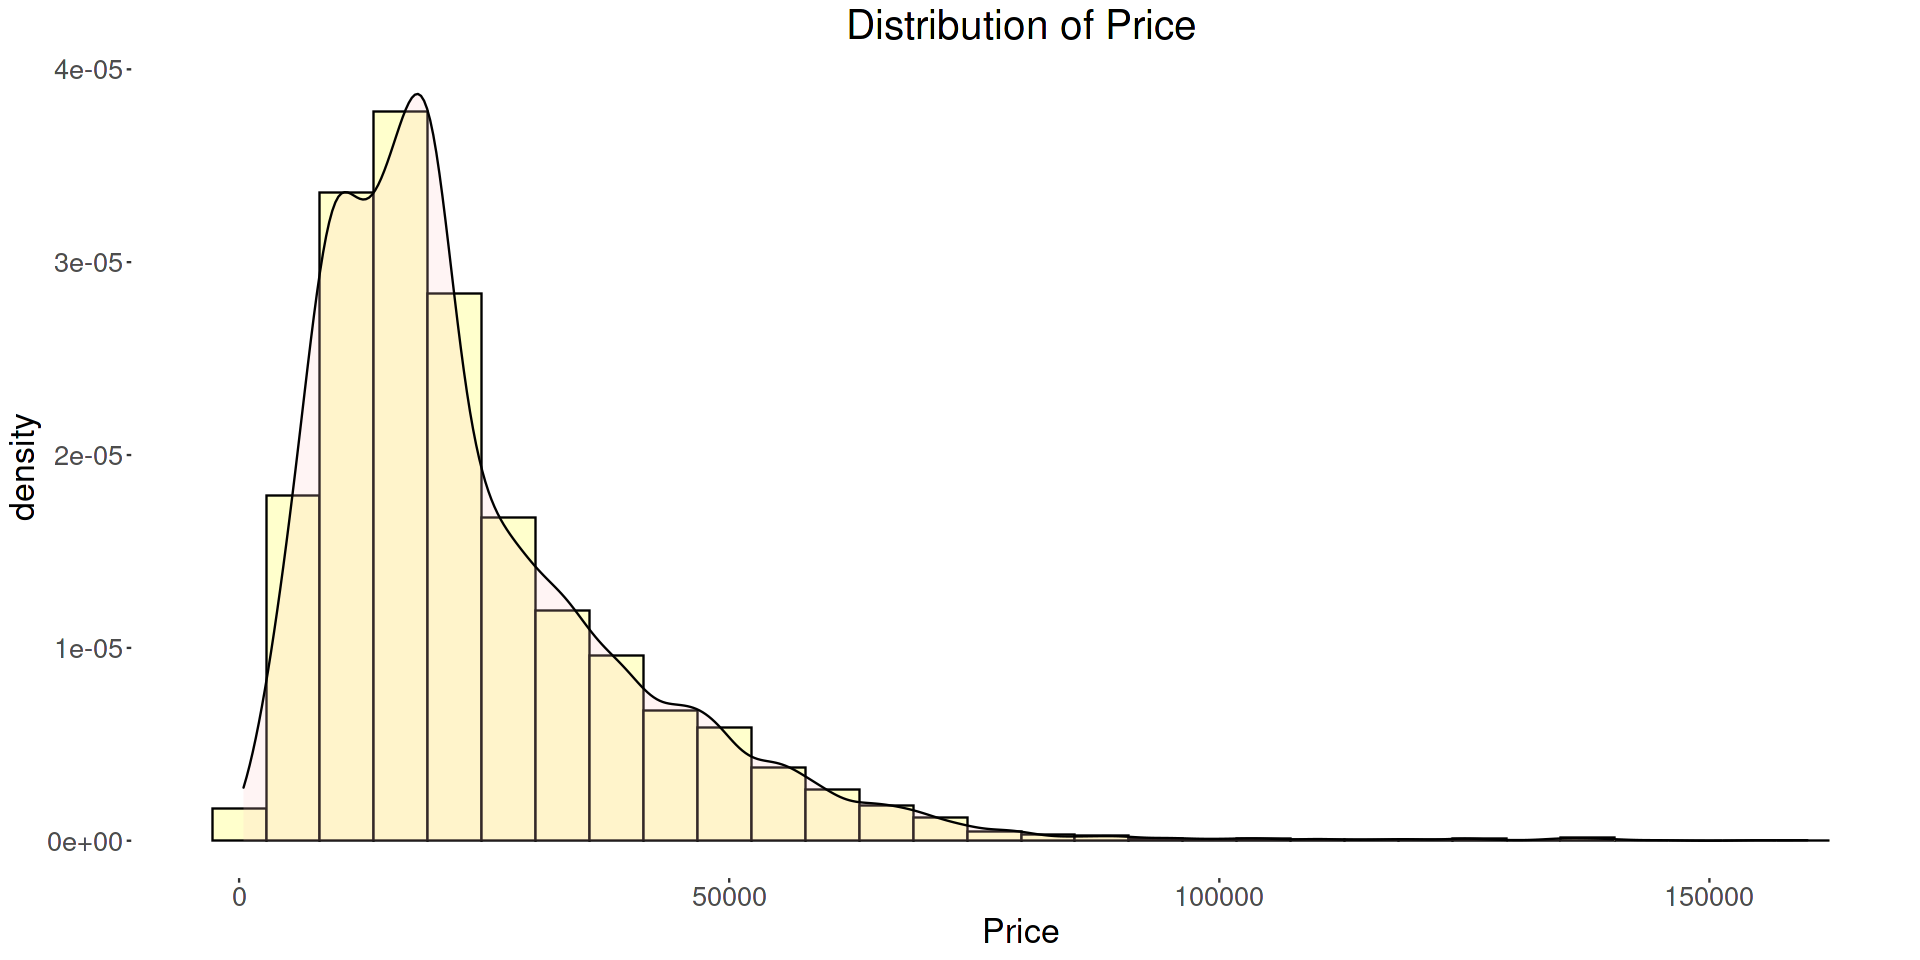

In [31]:
ggplot(data=full_data,aes(x=price))+
geom_histogram(aes(y=..density..), fill='#FFFFCC', color='black')+
geom_density(alpha=0.2,fill="#FFCCCC")+
xlab('Price')+
ggtitle('Distribution of Price')+
theme(panel.grid.major = element_blank(), 
        panel.background = element_rect('white'),
        text = element_text(size = 20),
        plot.title = element_text(hjust = 0.5))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



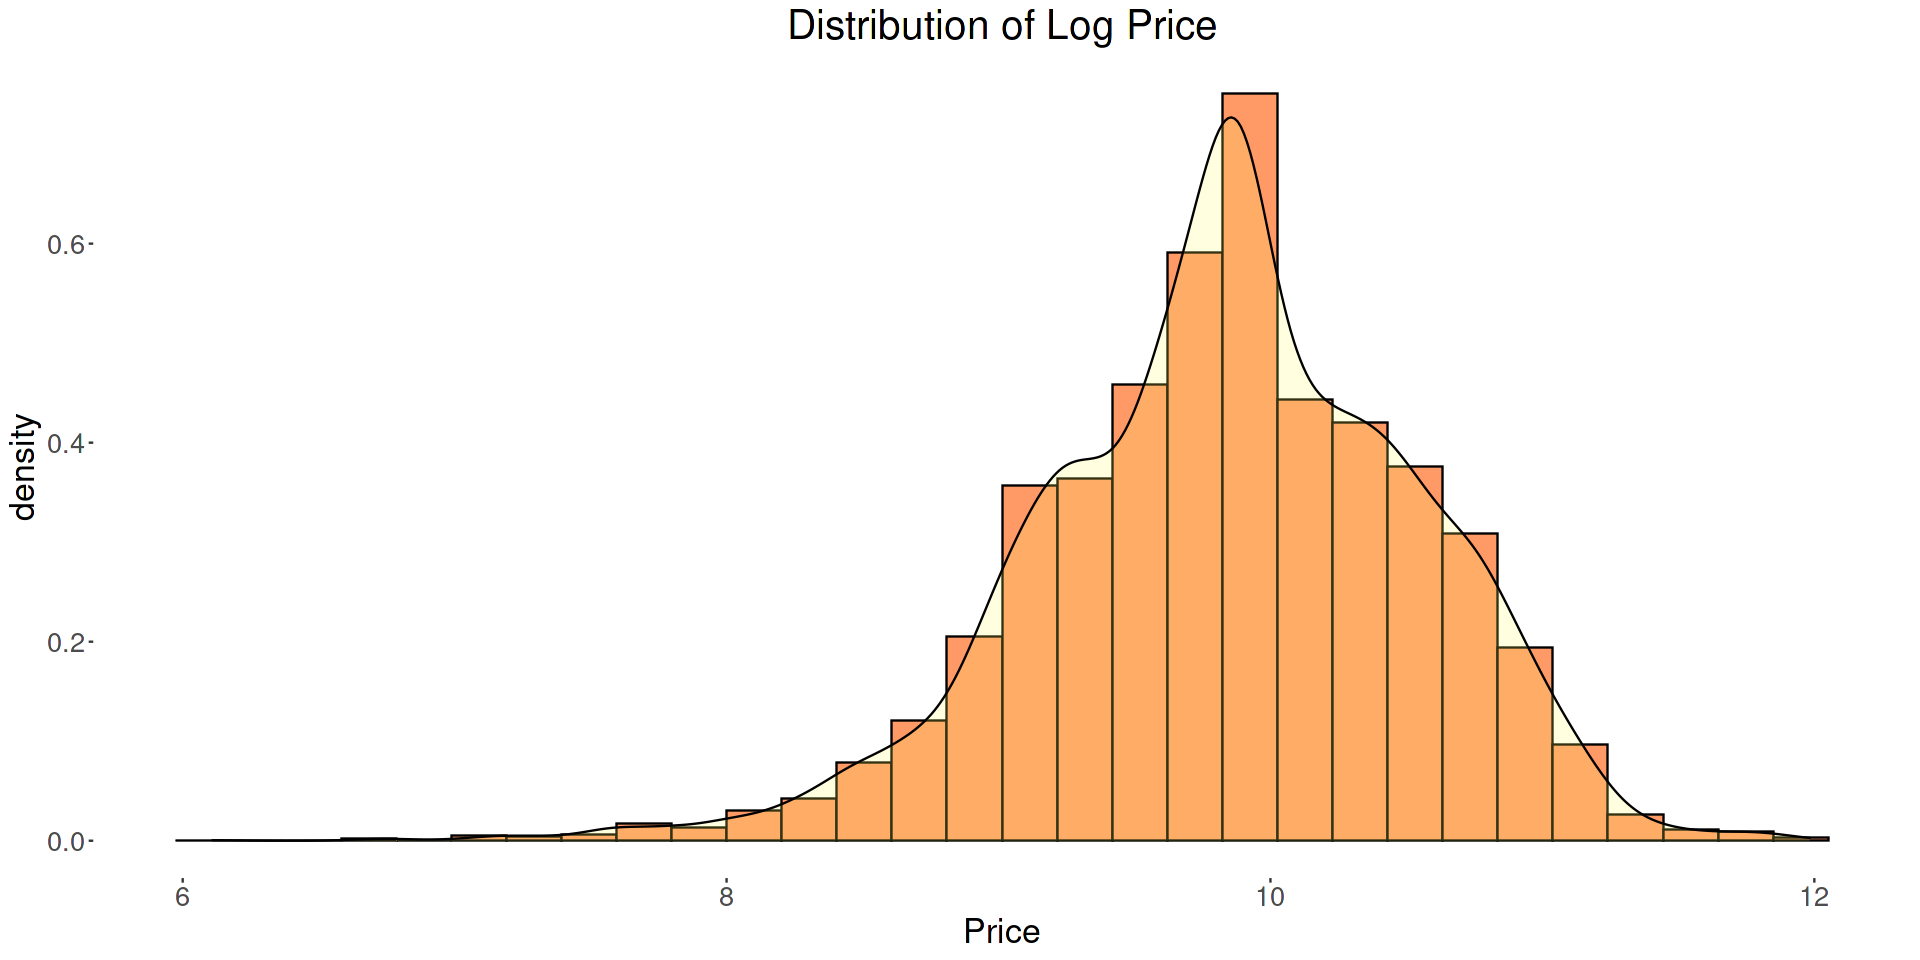

In [32]:
ggplot(data=full_data,aes(x=log(price)))+
geom_histogram(aes(y=..density..), fill='#FF9966', color='black')+
geom_density(alpha=0.2,fill="#FFFF66")+
xlab('Price')+
ggtitle('Distribution of Log Price')+
theme(panel.grid.major = element_blank(), 
        panel.background = element_rect('white'),
        text = element_text(size = 20),
        plot.title = element_text(hjust = 0.5))

# Time to build our models

### Data Transformations

In [33]:
# Price of the used cars seems to be positively skewed and I think a simple log transformation should balance the distribution.
full_data$price <- log(full_data$price)

# Also some of the predictors in our training data are skewed, also it's in different scale, so we can apply the same technique there

full_data$mileage <- log(full_data$mileage)

# We also have skewed mpg
full_data$mpg <- log(full_data$mpg)


### Seperate into training and test sets

In [34]:
id <- sample(nrow(full_data), floor(nrow(full_data)*0.75))

train <- full_data[id,]
test <- full_data[-id,]

test_response <- as.numeric(test[, 'price'])

test <- select(test, -price)

In [35]:
# Defining R-Squared function for measuring performance of our predictive models.
r_sqaured <- function(pred){
  rss <- sum((pred - test_response) ^ 2)
  tss <- sum((test_response - mean(test_response)) ^ 2)
  return(round(1-rss/tss, 3))
}

### Using caret library for cross validation and model selection

In [36]:
# Setting the resampling techniques using caret's trainControl function
fit_control <- trainControl(method = 'repeatedcv',
                            number = 10,
                            repeats = 4)

### Simple Linear Regression

In [37]:
# Building simple linear regression model using caret's train function
simplelrfit <- train(price~.,
                     data = train,
                     method = 'lm',
                     trControl = fit_control)
predsimplelrfit <- predict.train(simplelrfit, 
                                 newdata = test)

rsq_simplelrfit <- r_sqaured(pred = predsimplelrfit)

# After looking at the summary of the linear regression, we see that tax column in our datset 
#is not at all significant and so we drop it and actually it does not change any acuuracy value for any models which confirms this hypothesis.

In [38]:
cat('Simple Linear Regression R-Square - ', rsq_simplelrfit)

Simple Linear Regression R-Square -  0.934

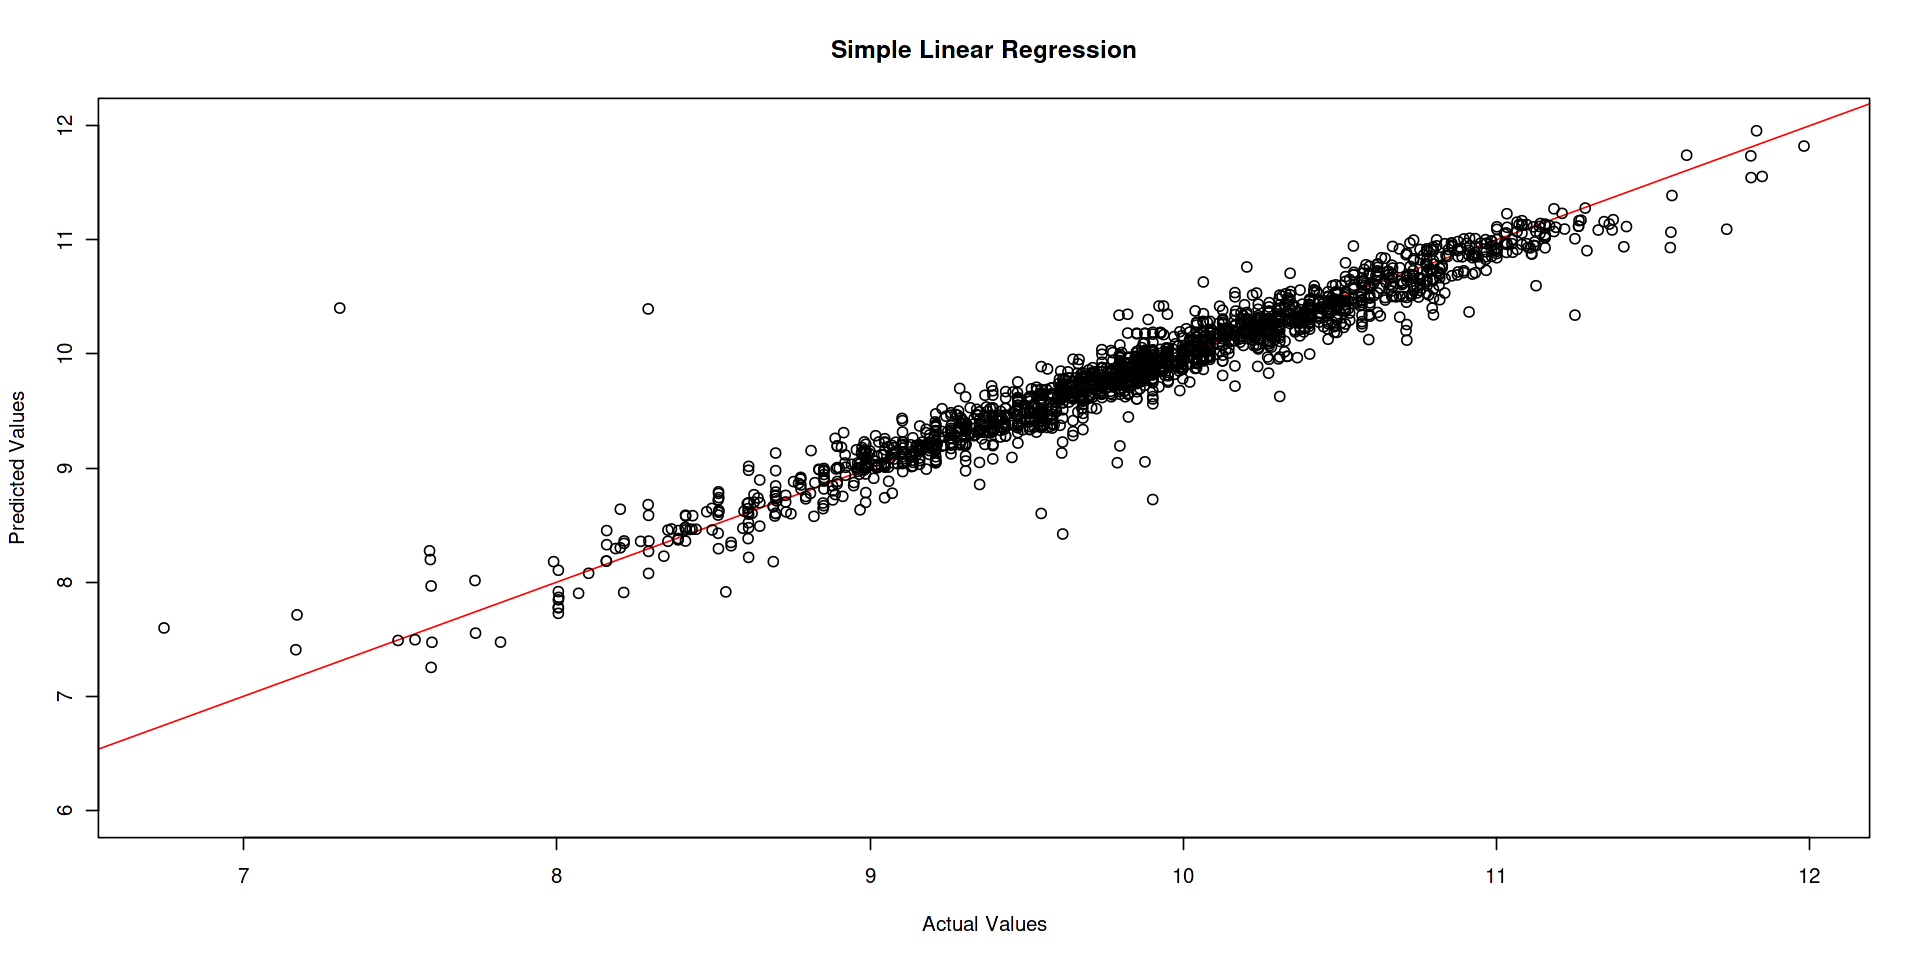

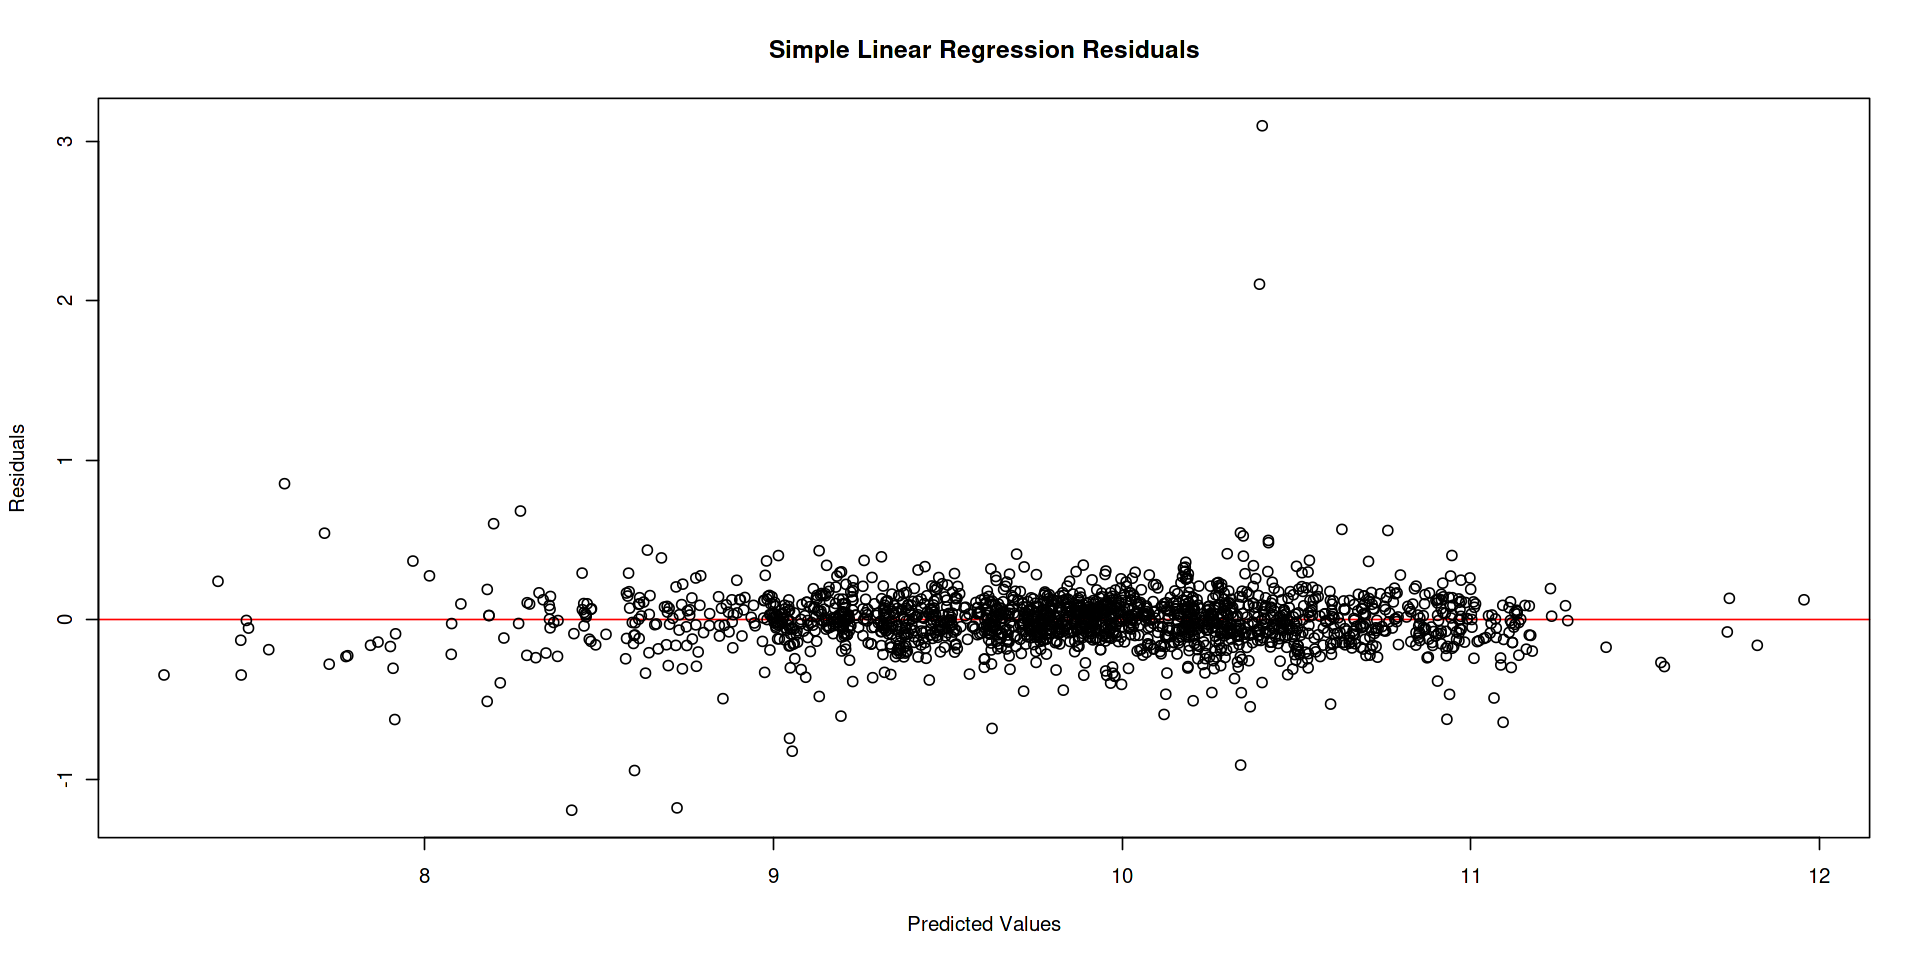

In [39]:
pred_plot <- plot(x = test_response, 
                  y = predsimplelrfit, 
                  xlab = 'Actual Values',
                  ylab = 'Predicted Values',
                  main = 'Simple Linear Regression',
                  ylim = c(6,12),
                  abline(a=0,b=1, col = 'red'))

resid_simplelr <- plot(x = predsimplelrfit,
                       y = predsimplelrfit - test_response,
                       abline(0,0,col = 'red'),
                       xlab = 'Predicted Values',
                       ylab = 'Residuals',
                       main = 'Simple Linear Regression Residuals')

### Ridge regression

In [40]:
# Now we try ridge regression to train our model and see how it works

ridgefit <- train(price~.,
                     data = train,
                     method = 'glmnet',
                     trControl = fit_control,
                     tuneGrid = expand.grid(data.frame(alpha = 0,
                                                       lambda = seq(0.0001, 0.1,0.001))))

# Optimal lambda chosen by the model is 0.0381, let's train using optimal lambda and measure our metric

optridgefit <- train(price~.,
                  data = train,
                  method = 'glmnet',
                  trControl = fit_control,
                  tuneGrid = expand.grid(data.frame(alpha = 0,
                                                    lambda = 0.0381)))

predridgefit <- predict.train(ridgefit, newdata = test)

rsq_ridgefit <- r_sqaured(predridgefit)

In [41]:
cat('Ridge Regression R-Square - ', rsq_ridgefit)

Ridge Regression R-Square -  0.936

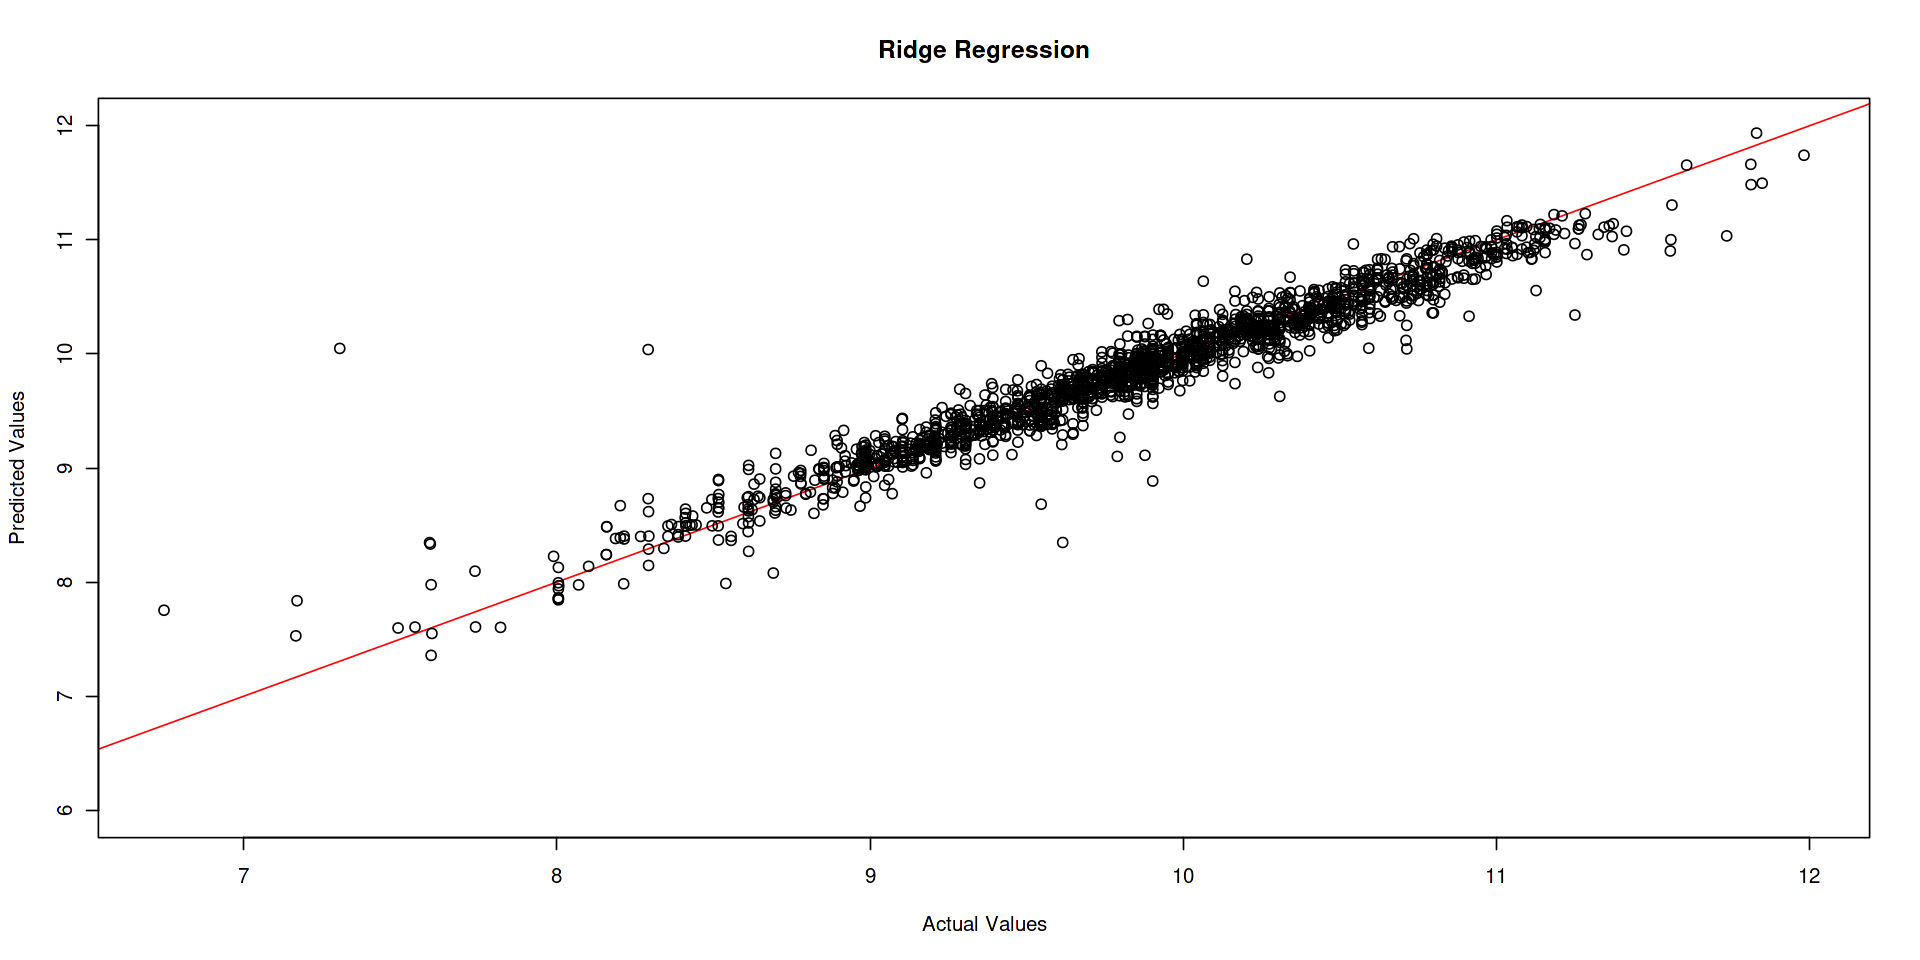

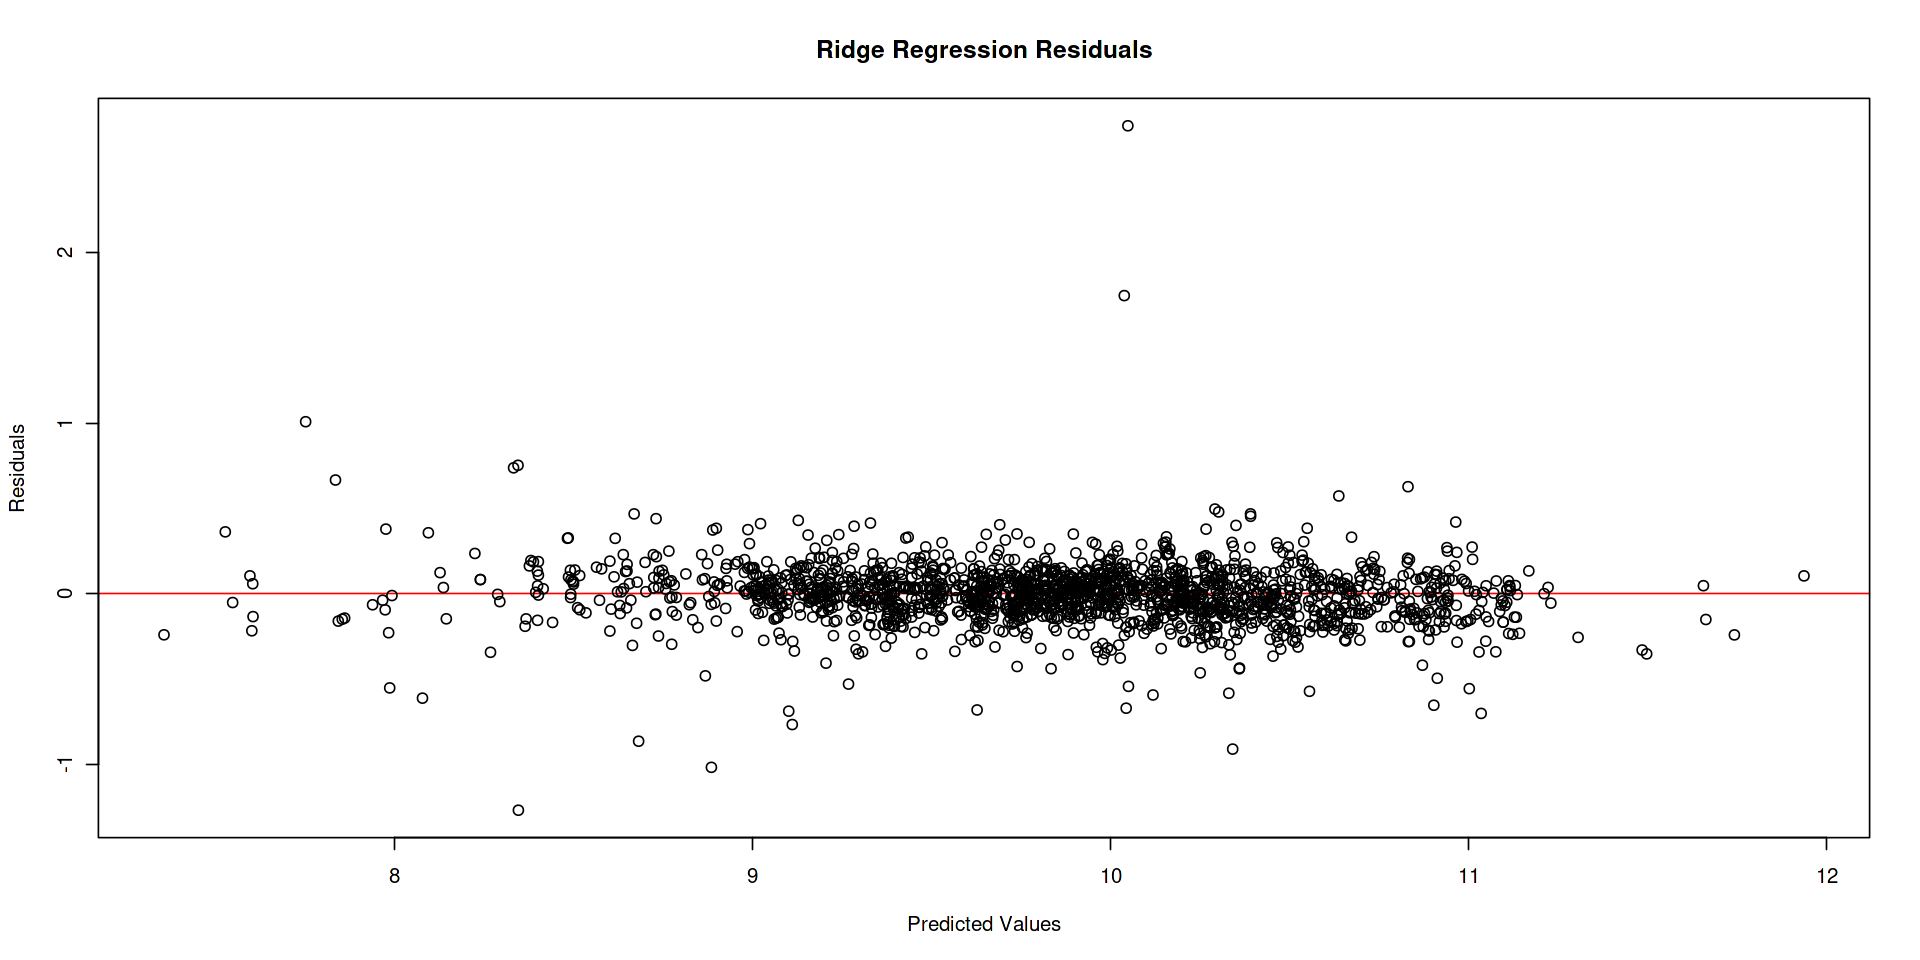

In [42]:
pred_plot <- plot(x = test_response, 
                  y = predridgefit, 
                  xlab = 'Actual Values',
                  ylab = 'Predicted Values',
                  main = 'Ridge Regression',
                  ylim = c(6,12),
                  abline(a=0,b=1, col = 'red'))

resid_simplelr <- plot(x = predridgefit,
                       y = predridgefit - test_response,
                       abline(0,0,col = 'red'),
                       xlab = 'Predicted Values',
                       ylab = 'Residuals',
                       main = 'Ridge Regression Residuals')

### Lasso Regression

In [43]:
# Now we try Lasso regression to train our model and see how it works 

lassofit <- train(price~.,
                  data = train,
                  method = 'glmnet',
                  trControl = fit_control,
                  tuneGrid = expand.grid(data.frame(alpha = 1,
                                                    lambda = seq(0.00001, 0.01,0.0001))))

# Optimal lambda was given by the model is 0.00031, let's train our model using optimal lambda and measure our model

optlassofit <- train(price~.,
                  data = train,
                  method = 'glmnet',
                  tuneGrid = expand.grid(data.frame(alpha = 1,
                                                    lambda = 0.00021)))

predlassofit <- predict.train(optlassofit, newdata = test)

rsq_lassofit <- r_sqaured(predlassofit)

In [44]:
cat('Ridge Regression R-Square - ', rsq_lassofit)

Ridge Regression R-Square -  0.937

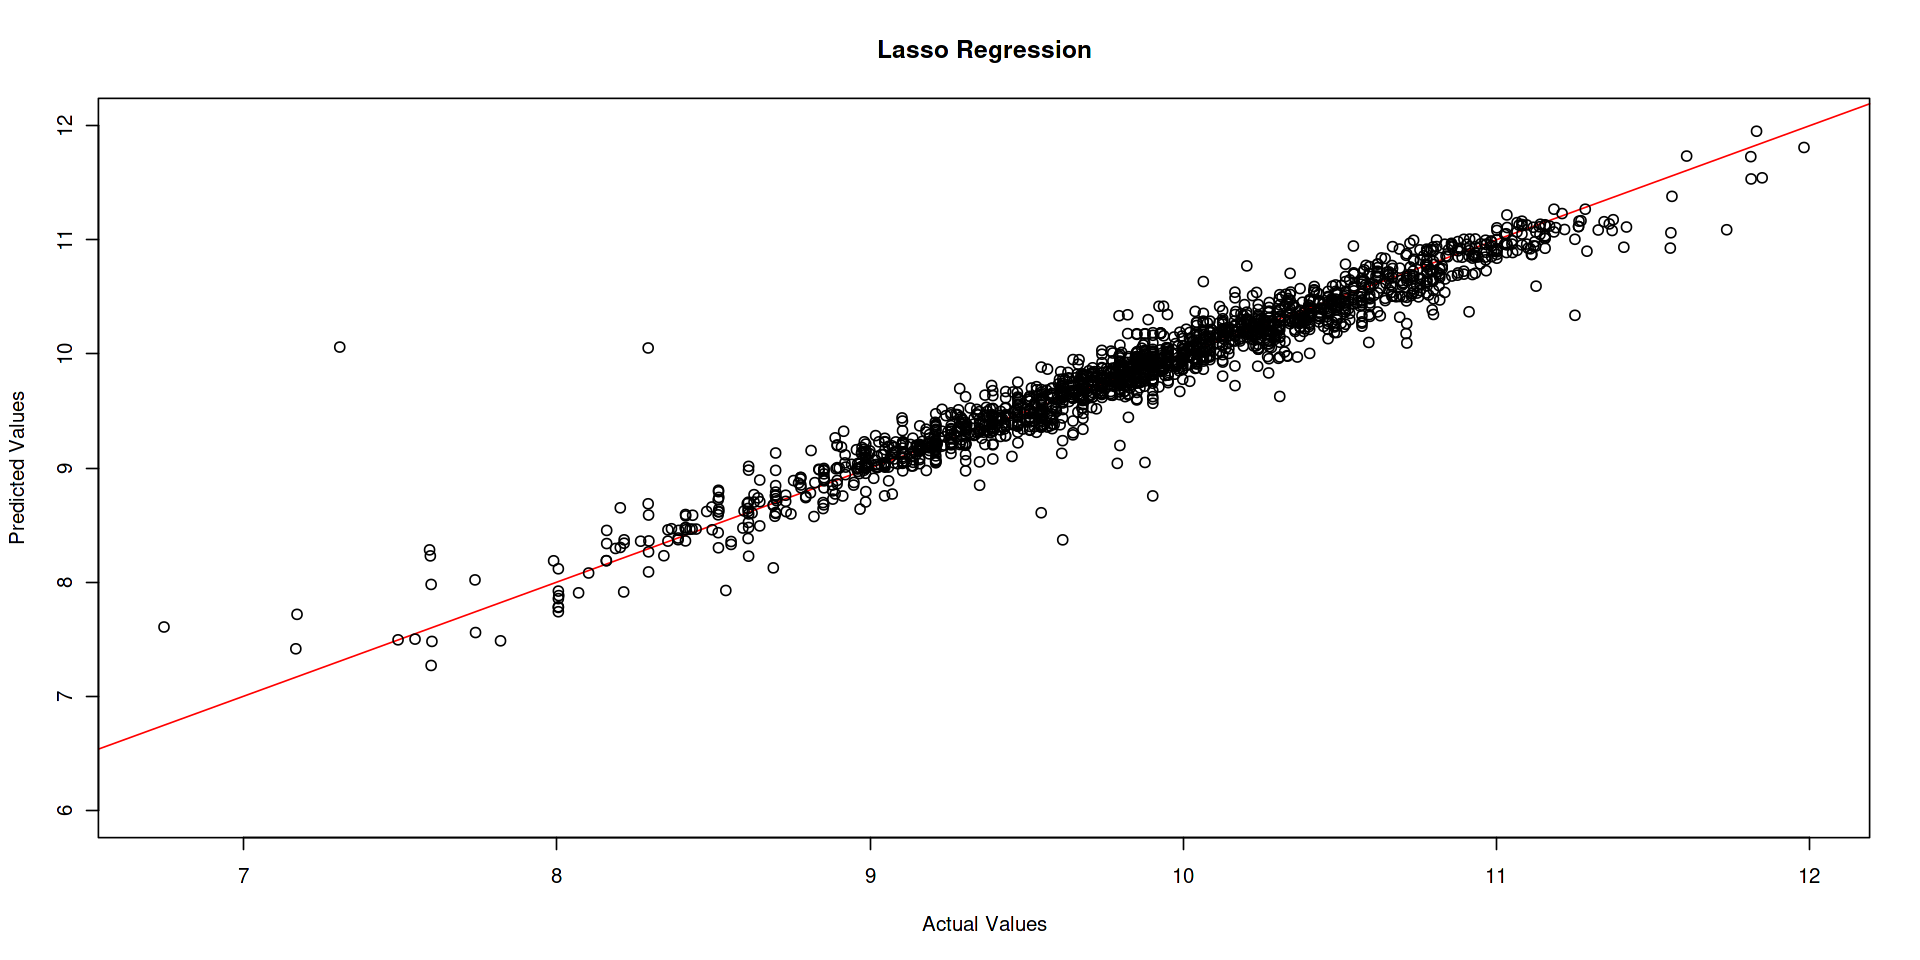

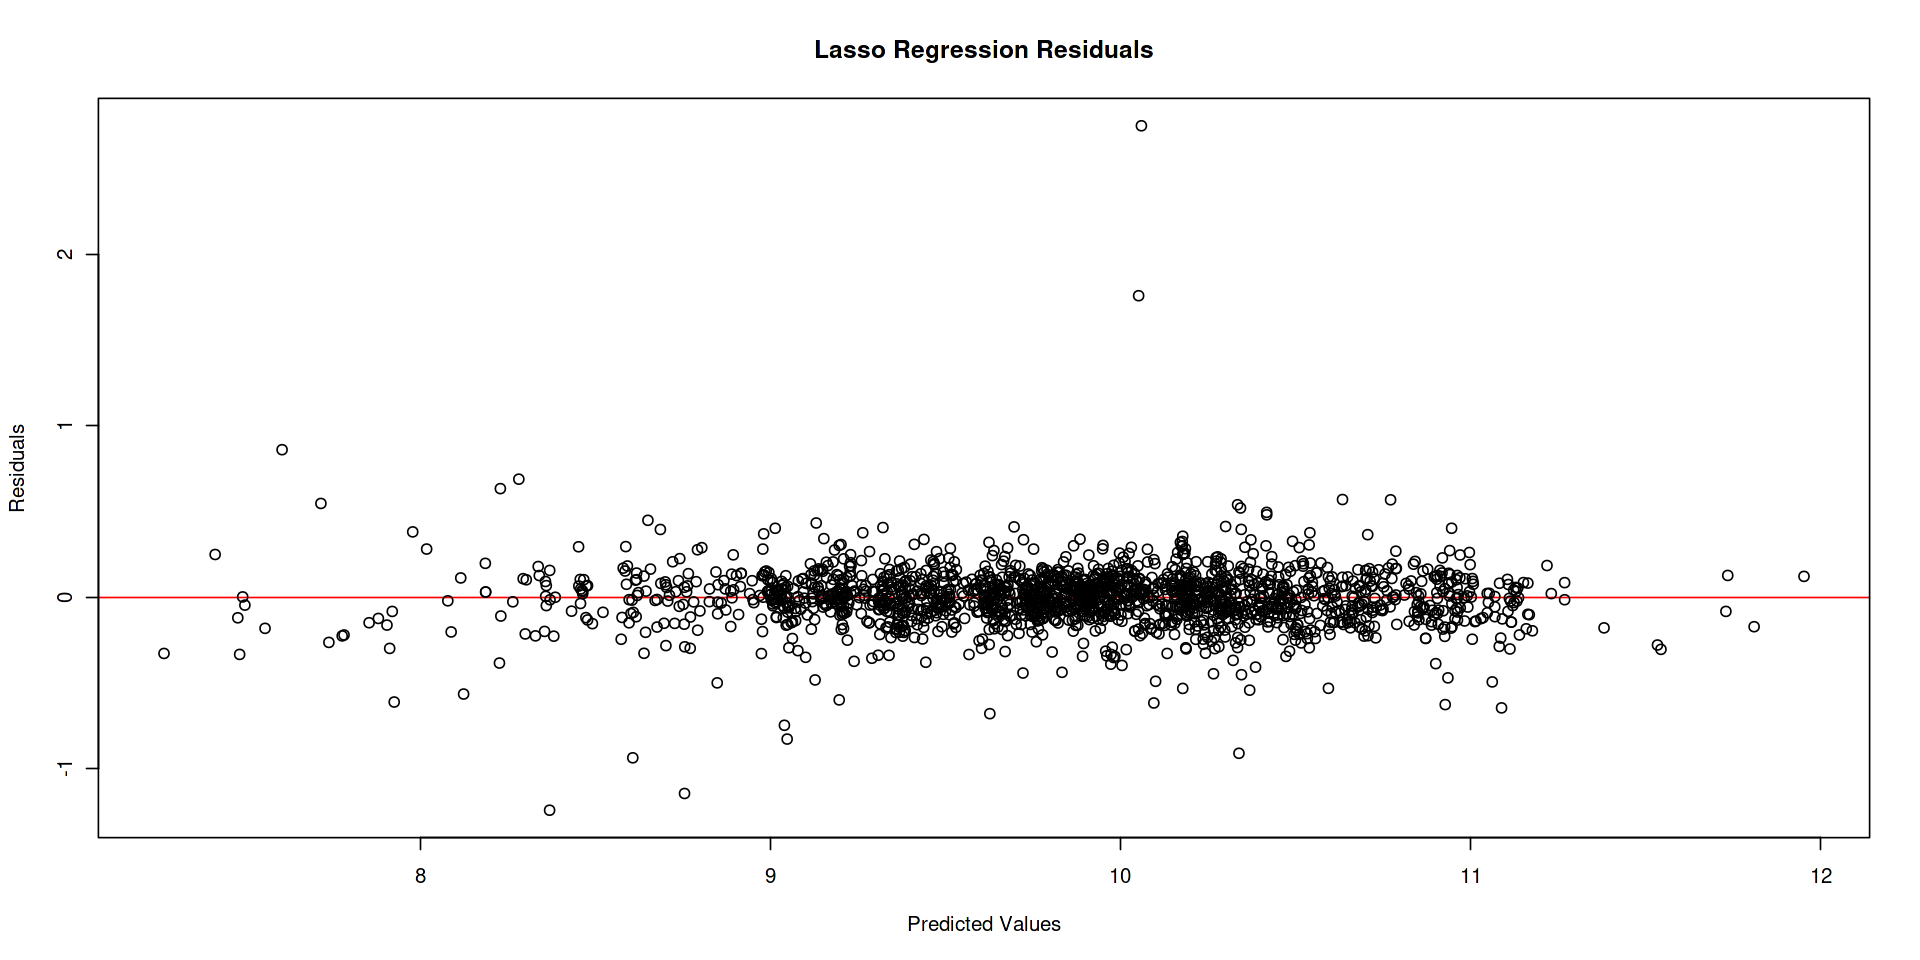

In [45]:
pred_plot <- plot(x = test_response, 
                  y = predlassofit, 
                  xlab = 'Actual Values',
                  ylab = 'Predicted Values',
                  main = 'Lasso Regression',
                  ylim = c(6,12),
                  abline(a=0,b=1, col = 'red'))

resid_simplelr <- plot(x = predlassofit,
                       y = predlassofit - test_response,
                       abline(0,0,col = 'red'),
                       xlab = 'Predicted Values',
                       ylab = 'Residuals',
                       main = 'Lasso Regression Residuals')

### Decision Trees

In [46]:
# Now we are going to try decision trees on our dataset and measure the performance of our model

dtrpartfit <- train(price~.,
               data = train,
               method = 'rpart',
               trControl = fit_control,
               tuneLength =20)

# Optimal cp value chosen was cp = 0.0013 

preddtfit <- predict.train(dtrpartfit, newdata = test)

rsq_dtrpartfit <- r_sqaured(preddtfit)

In [47]:
cat('Decision Tree R-Square - ', rsq_dtrpartfit)

Decision Tree R-Square -  0.761

### Random Forests

In [48]:
# Now we are going to try random forests on our dataset and measure the performance of our model.


set.seed(123)


hyper_grid <- expand.grid(mtry= seq(1,8,1),
                          node_size = seq(5, 15, 5),
                          sampe_size = c(0.55,0.632,0.70,0.80,1),
                          OOB_RMSE = 0)



for (i in 1:nrow(hyper_grid)) {
  ranger_rf <- ranger(price~., 
                      data = train, num.trees = 500, 
                      mtry = hyper_grid$mtry[i], 
                      min.node.size = hyper_grid$node_size[i], 
                      sample.fraction = hyper_grid$sampe_size[i],
                      seed = 123)
  
hyper_grid$OOB_RMSE[i] <- sqrt(ranger_rf$prediction.error)
  }

# Above ranger object gives us out optimal tree of mtry = 3, node size = 5, and sample size of 100% of train data.
 
# We use this optimal random forest tree to predict our house prices using test data

pred_ranger <- predict(ranger_rf, data = test)

rsq_ranforfit <- r_sqaured(pred_ranger$predictions)

In [49]:
cat('Random Forest R-Square - ', rsq_ranforfit)

Random Forest R-Square -  0.961

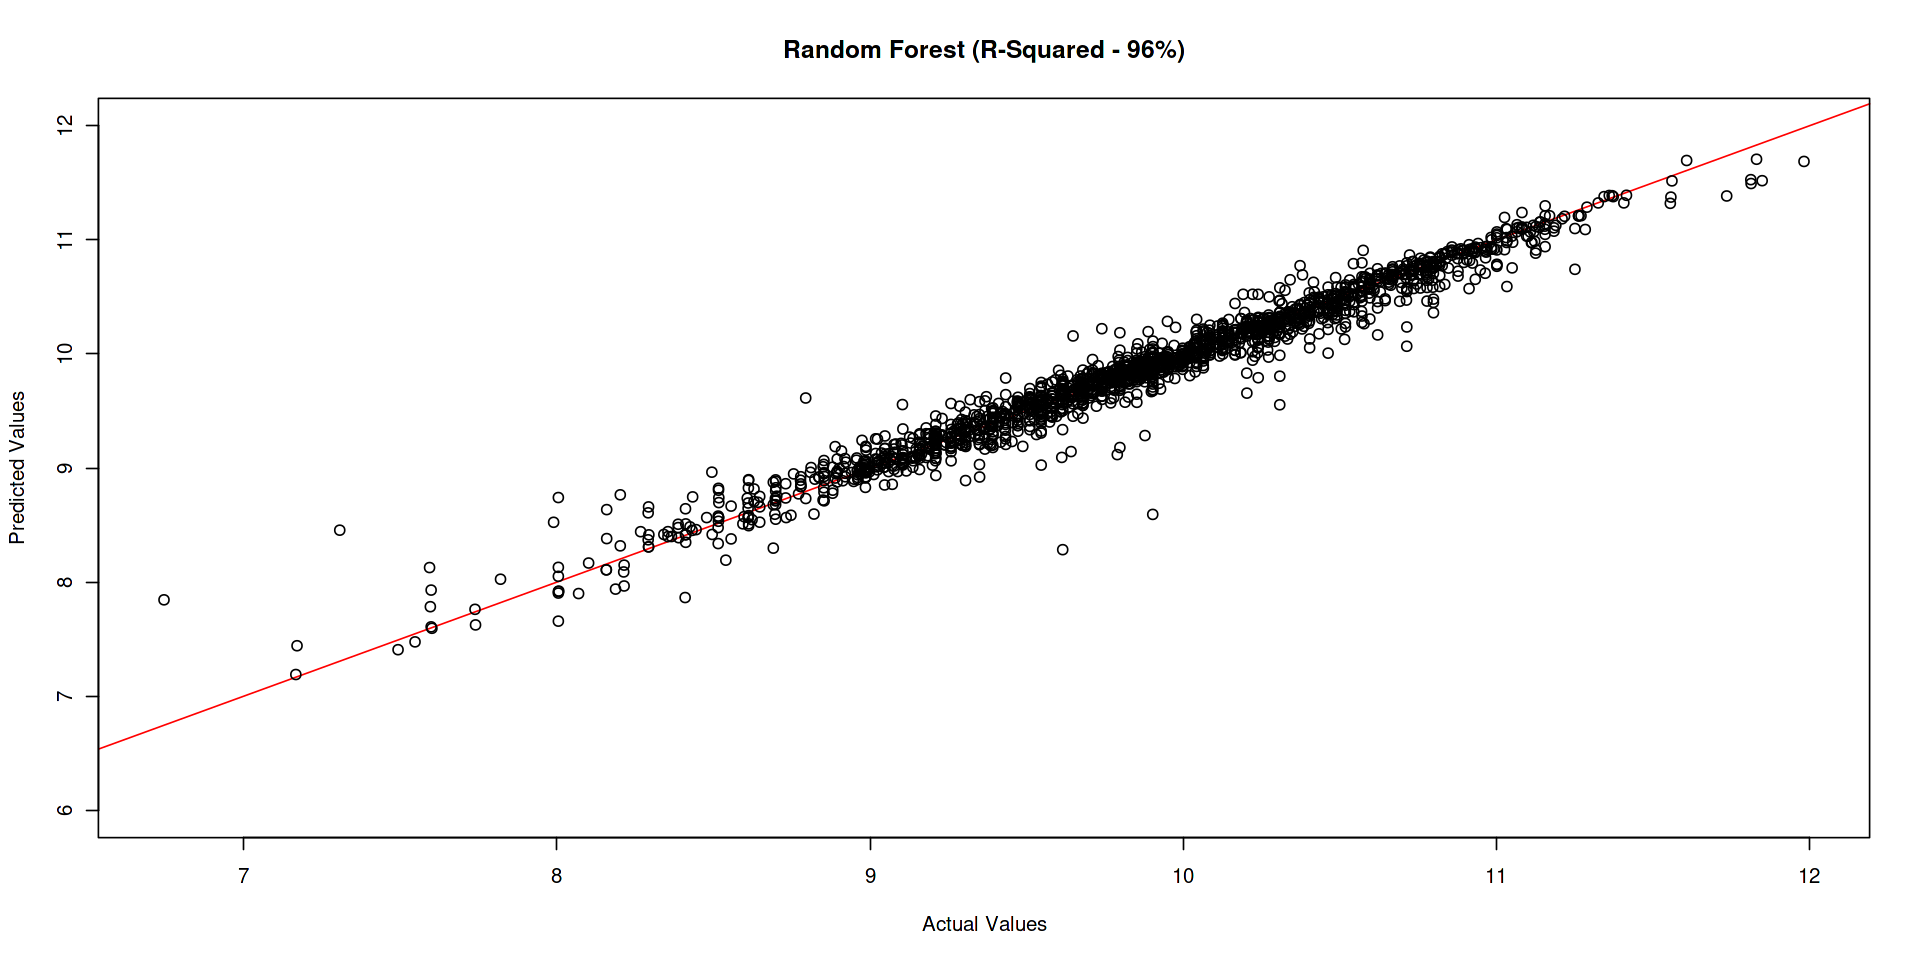

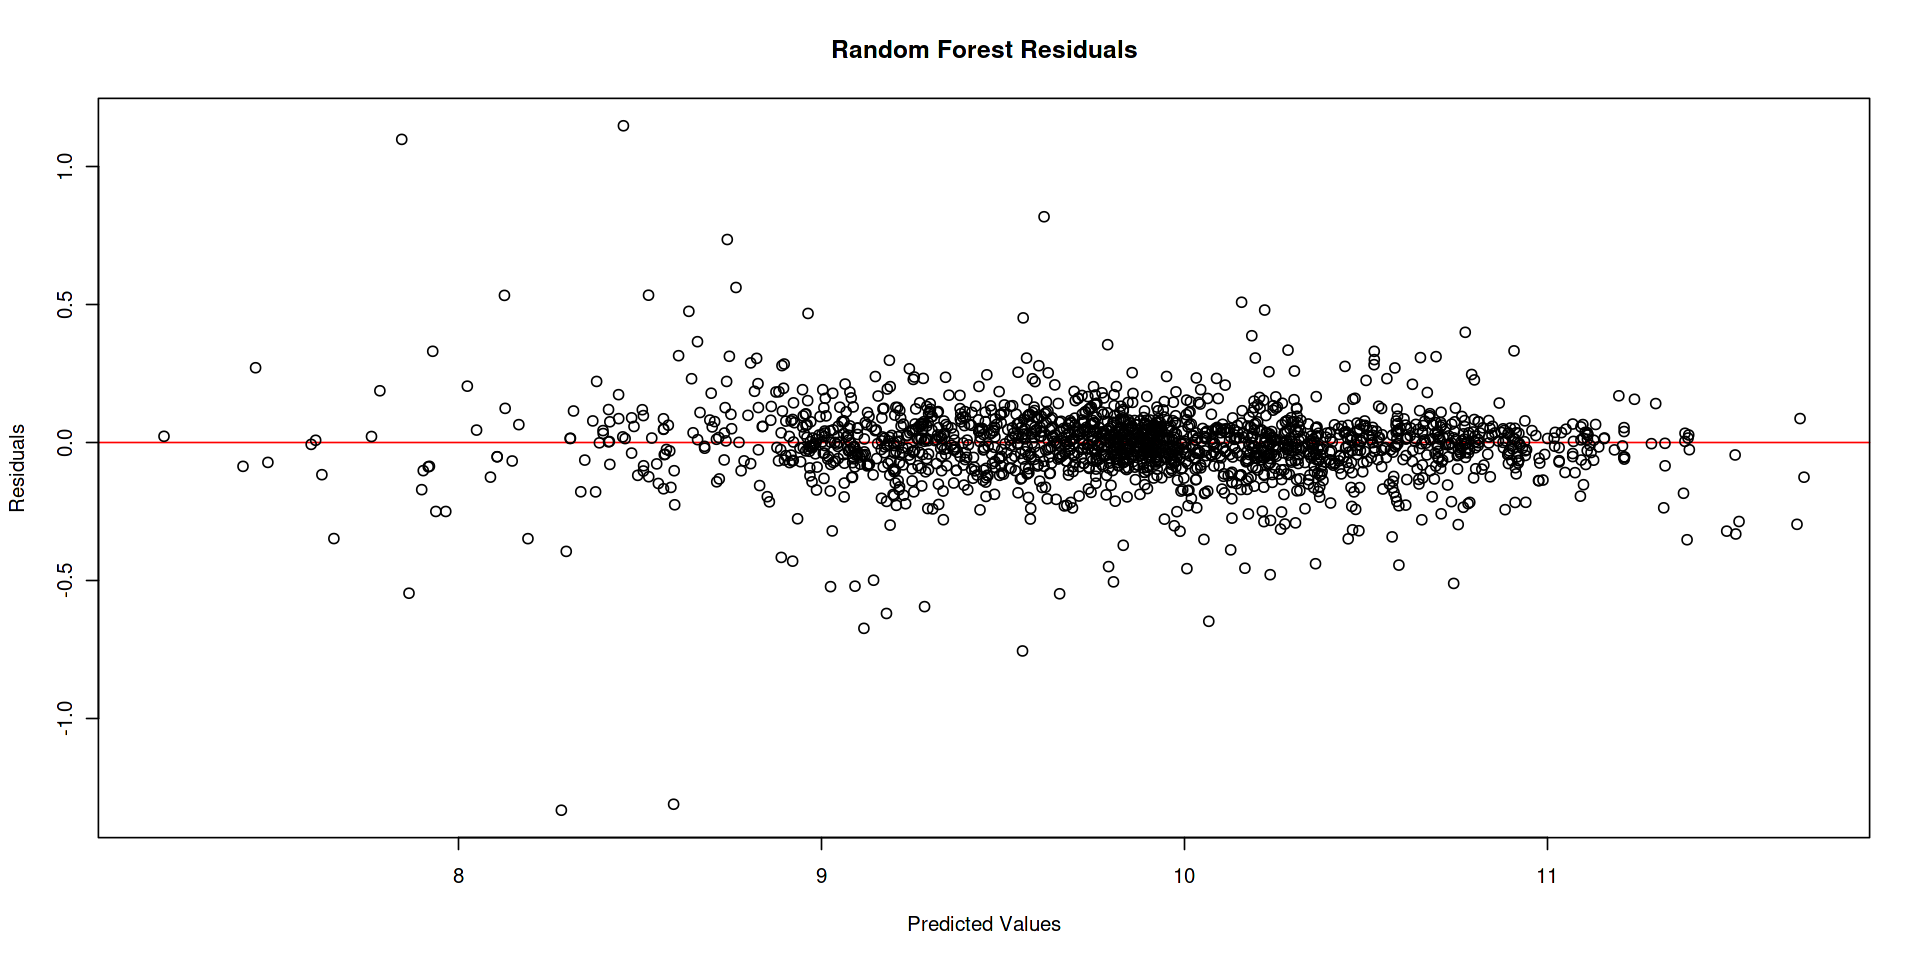

In [50]:
pred_plot_ranfo <- plot(x = test_response, 
                  y = pred_ranger$predictions, 
                  xlab = 'Actual Values',
                  ylab = 'Predicted Values',
                  main = 'Random Forest (R-Squared - 96%)',
                  ylim = c(6,12),
                  abline(a=0,b=1, col = 'red'))

resid_ranfor <- plot(x = pred_ranger$predictions,
                       y = pred_ranger$predictions - test_response,
                       abline(0,0,col = 'red'),
                       xlab = 'Predicted Values',
                       ylab = 'Residuals',
                       main = 'Random Forest Residuals')

### Support Vector Machines - Regression

In [51]:
# We tune our SVR model by trying various gamma, costs and epsilon values. The code is commented because it takes around 2 hours to find optimum
# parameters and the model was run on machine previously to find the hyperparameters

gammas <- 2^(-3:3)
costs <- 2^(-3:3)
epsilon <- c(0.1,0.01,0.001)

#svmtune <- tune.svm(price~.,
#                data = train,
#                gamma = gammas,
#                cost = costs,
#                epsilon = epsilon)

In [52]:
# SVR was trained using radial basis kernel

svmoptimal <- svm(price~., 
                  data = train, 
                  scale = T, 
                  type = 'eps-regression', 
                  kernel = 'radial', 
                  gamma = 0.125, 
                  cost=4, 
                  epsilon = 0.01 )


predsvm <- predict(svmoptimal, newdata = test)

rsq_svm <- r_sqaured(predsvm)

In [53]:
cat('Support Vector Regression R -Square: ', rsq_svm)

Support Vector Regression R -Square:  0.968

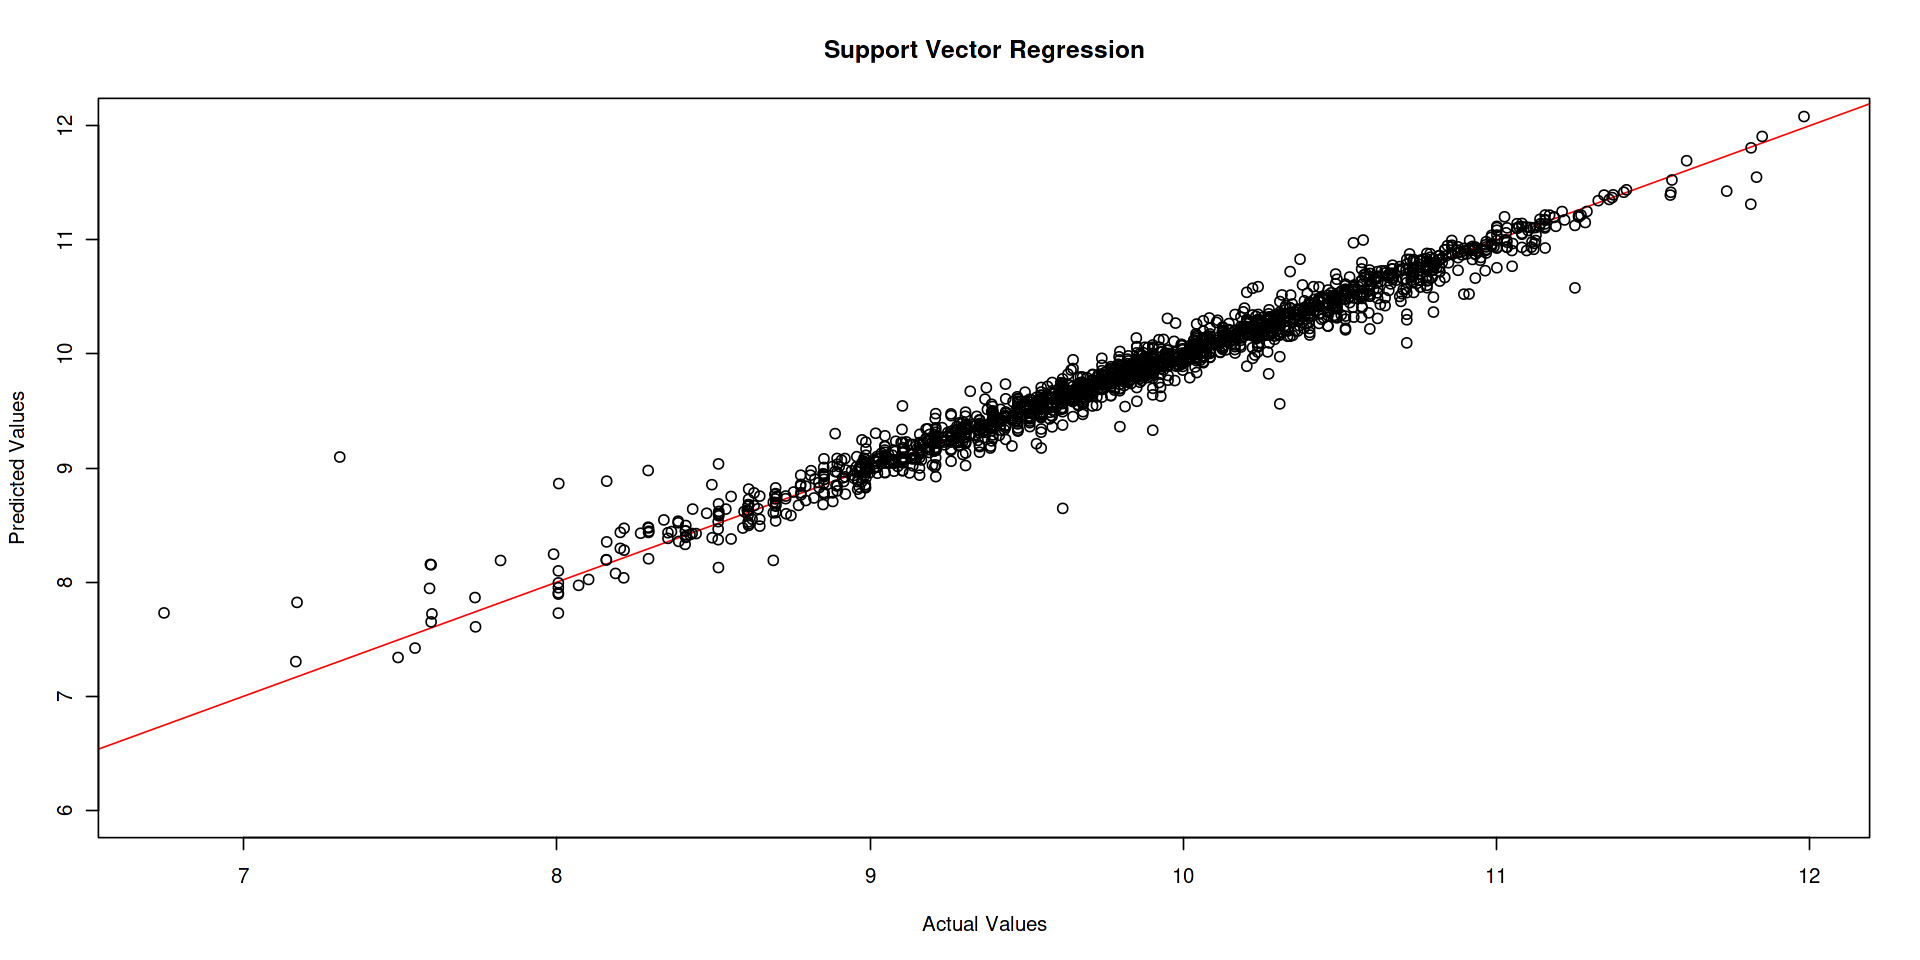

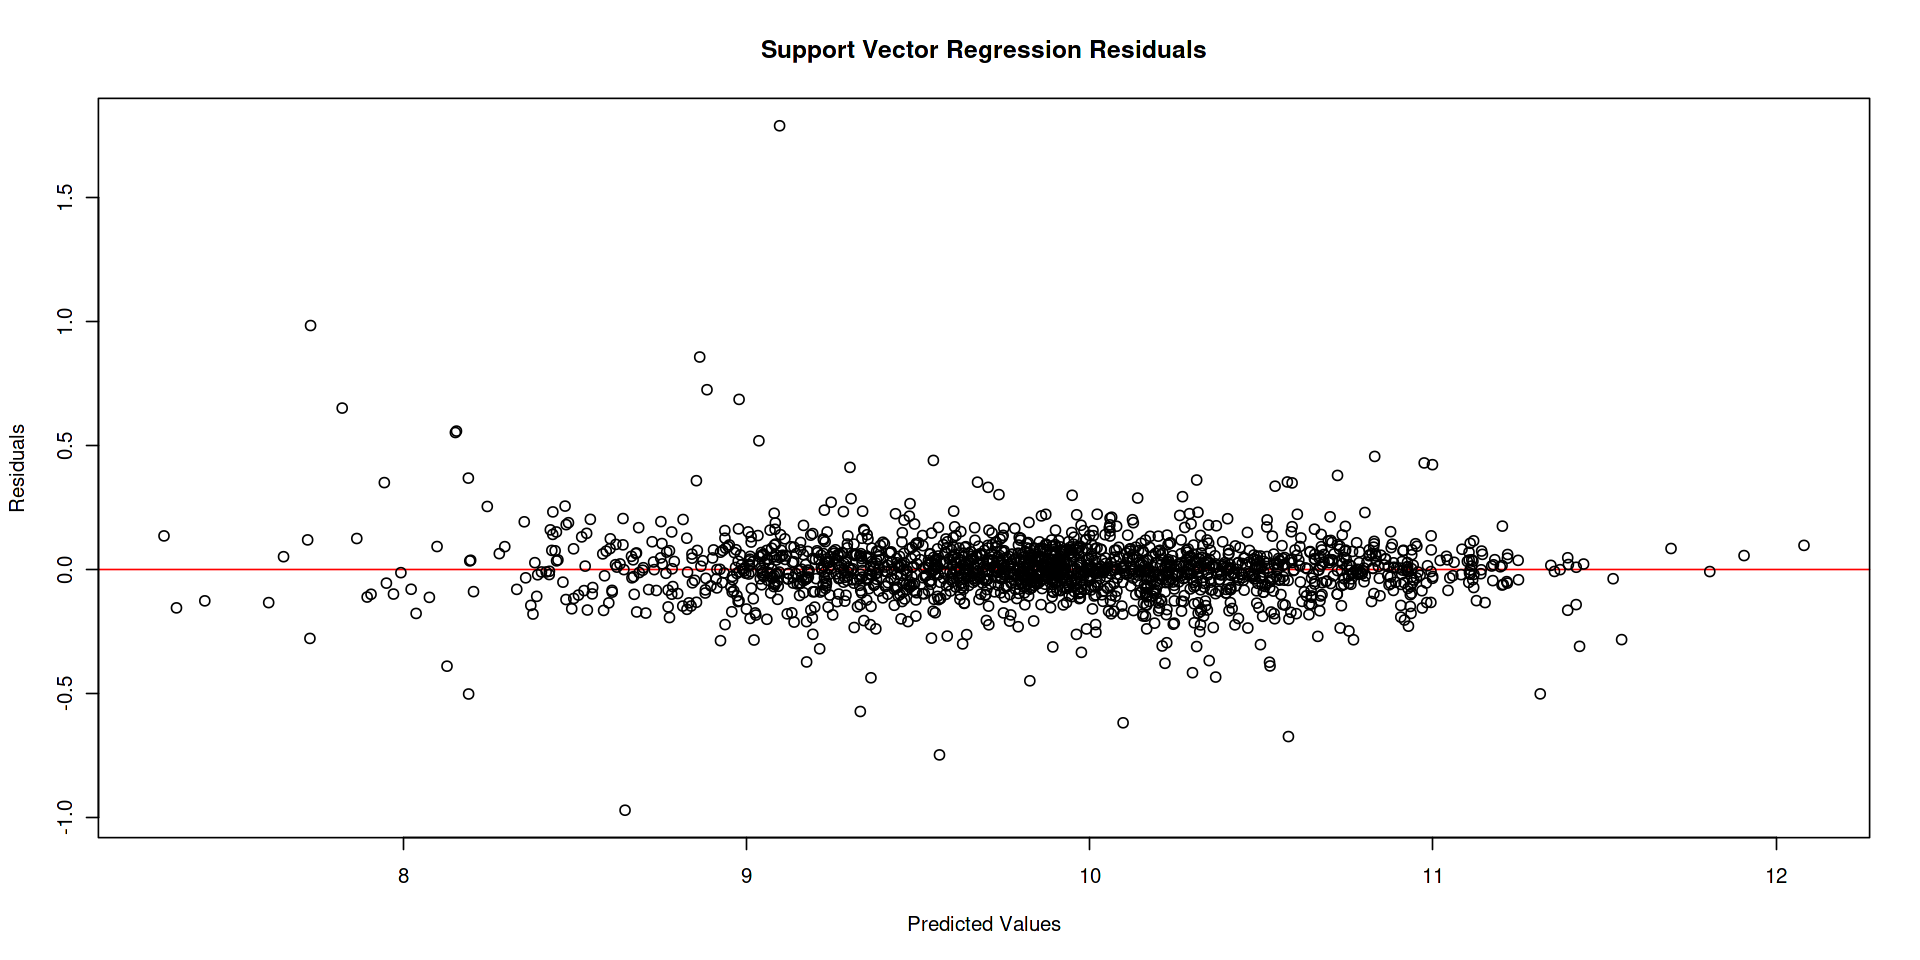

In [54]:
pred_plot <- plot(x = test_response, 
                  y = predsvm, 
                  xlab = 'Actual Values',
                  ylab = 'Predicted Values',
                  main = 'Support Vector Regression',
                  ylim = c(6,12),
                  abline(a=0,b=1, col = 'red'))

resid_simplelr <- plot(x = predsvm,
                       y = predsvm - test_response,
                       abline(0,0,col = 'red'),
                       xlab = 'Predicted Values',
                       ylab = 'Residuals',
                       main = 'Support Vector Regression Residuals')

# As we can see, Support Vector Machine has become the strongest Jedi of all the models present here and it is also a beautiful model with its own idiosyncracies which were exploited in getting us an R-Sqaured value of around 0.97 for this specific dataset. 